In [1]:
# import pytorch libraries
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

import re
import os
import csv
import copy
import math
import time
import random
import pickle
import argparse
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import mse
from collections import Counter
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import rankdata
from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score, average_precision_score

# use gpu if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# some settings
seed = 2024
train_partition = 1.0

In [2]:
### directory ###
# this is the directory where you save your preprocessing data from clinical trials
ct_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Drug_combinations/06122025/clinical_trail_preprocessing/'
# this is the directory where you have the cleaned drkg embeddings for drugs and conditions
drkg_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Drug_combinations/06122025/drkg_embedding_preprocessing/'
# this is the directory where you save the drugs and conditions embeddings after training and finetuning
emb_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Drug_combinations/06122025/embedding_training_and_finetuning/'
# this is the directory where you save the cdcdb triplets tables
cdcdb_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Drug_combinations/06122025/cdcdb_triplets_preprocessing/'
# this is the directory where you plan to save the model running and evaluation results
save_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Drug_combinations/06122025/final_model/results/'
# this is the directory to the Oncodrug clean csv file
Onco_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Drug_combinations/06122025/Oncodrug/'

In [3]:
#####-----read data from clinical trials-----#####
# table of clean clinical trials with info of 1 drug and 1 condition
drug_cond_df = pd.read_csv(ct_dir + 'drug_condition.txt', delimiter='\t')
print(f"There are {drug_cond_df.shape[0]} drug-condition pairs from AACT clinical trials.")
# clinical trial triplets
two_drugs_comb_df = pd.read_csv(ct_dir + 'dcombinations_w_conditions.txt', delimiter='\t')
# Sort the first two drugs in each row
two_drugs_comb_df[['drug1', 'drug2']] = two_drugs_comb_df[['drug1', 'drug2']].apply(lambda row: pd.Series(sorted(row)), axis=1)

#####-----Load the embeddings-----#####
# find the drug and cond that have corresponding embeddings in DRKG dataset
embedding_drug=pd.read_csv(drkg_dir + 'drkg_filtered_drug_embedding.csv')
embedding_drug=embedding_drug.set_index('id')
embedding_drug1=embedding_drug.reindex(drug_cond_df['drug'].unique())
embedding_drug1=embedding_drug1.dropna()
embedding_cond=pd.read_csv(drkg_dir + 'drkg_filtered_condition_embedding.csv')
embedding_cond=embedding_cond.set_index('id')
embedding_cond1=embedding_cond.reindex(drug_cond_df['condition'].unique())
embedding_cond1=embedding_cond1.dropna()

# count the number of nodes of each kind
n_emb = len(embedding_cond1) + len(embedding_drug1)
n_drug = len(set(drug_cond_df['drug']))
n_drug_w_emb = embedding_drug1.shape[0]
n_cond = len(set(drug_cond_df['condition']))
n_cond_w_emb = embedding_cond1.shape[0]
N_node = n_cond + n_drug

input_emb_size = 400
# merge the drug embeddings and condition embeddings
merged_emb = pd.concat([embedding_drug1, embedding_cond1], ignore_index=False)
# load pretrained drkg embeddings
pretrained_embedding = torch.nn.Embedding(n_emb, input_emb_size)
drkg_emb = torch.tensor(merged_emb.values, dtype=torch.float32)
pretrained_embedding.weight = torch.nn.Parameter(drkg_emb)
# load the trained embeddings
embedding_save_path = emb_dir+'trained_emb.npy'
trained_emb_weights = np.load(embedding_save_path)
trained_embedding = torch.nn.Embedding(N_node-n_emb, input_emb_size)
trained_embedding.weight.data.copy_(torch.from_numpy(trained_emb_weights))
# concat two embeddings layers together
embeddings = torch.cat((pretrained_embedding.weight, trained_embedding.weight), dim=0) 

# reindex the existing DRKG embeddings
emb_id_mapping = {emb_id: i for i, emb_id in enumerate(merged_emb.index)}
# find all the drugs and conditions without DRKG embeddings
for i in range(drug_cond_df.shape[0]):
    drug_name = drug_cond_df['drug'][i]
    if drug_name not in emb_id_mapping.keys():
        emb_id_mapping[drug_name] = max(emb_id_mapping.values())+1
for i in range(drug_cond_df.shape[0]):
    cond_name = drug_cond_df['condition'][i]
    if cond_name not in emb_id_mapping.keys():
        emb_id_mapping[cond_name] = max(emb_id_mapping.values())+1

# map the drug or cond ids into indices for drug_cond_df
import warnings
warnings.filterwarnings("ignore")
drug_cond_df['drug_idx'] = drug_cond_df['drug'].map(emb_id_mapping)
drug_cond_df['cond_idx'] = drug_cond_df['condition'].map(emb_id_mapping)

# find all unique drugs and conditions in clinical trials
all_drug_list = drug_cond_df['drug'].tolist()
all_cond_list = drug_cond_df['condition'].tolist()
unique_drug_list = sorted(list(set(drug_cond_df['drug'].tolist())))
unique_cond_list = sorted(list(set(drug_cond_df['condition'].tolist())))

# filter out the combinations we can use from clinical trials
pick_row = []
for i in range(two_drugs_comb_df.shape[0]):
    if two_drugs_comb_df['drug1'][i] in all_drug_list:
        if two_drugs_comb_df['drug2'][i] in all_drug_list:
            if two_drugs_comb_df['condition'][i] in all_cond_list:
                pick_row.append(i)
pick_comb_df = two_drugs_comb_df.iloc[pick_row,:].reset_index(drop=True)
pick_comb_df['drug1_idx'] = pick_comb_df['drug1'].map(emb_id_mapping)
pick_comb_df['drug2_idx'] = pick_comb_df['drug2'].map(emb_id_mapping)
pick_comb_df['cond_idx'] = pick_comb_df['condition'].map(emb_id_mapping)
# this is the final clean table for drug combination + condition from clinical trial
pick_comb_df = pick_comb_df.drop_duplicates().reset_index(drop=True)

#####-----Load CDCDB triplets-----#####
# read cdcdb dcomb
cdcdb_dcomb_file = cdcdb_dir+'drugcombo_max2_drugs_conditions_MeSH_IDs.txt'
cdcdb_dcomb = pd.read_csv(cdcdb_dcomb_file, sep='\t')
# build the drug comb + condition files
drug1_list, drug2_list, cond_list = [], [], []
for i in range(cdcdb_dcomb.shape[0]):
    db_string = cdcdb_dcomb['drugbank_identifiers'][i]
    split_strings = db_string.split(';')
    drug_pair = []
    for s in split_strings:
        drug_pair.extend(re.findall(r'DB\S+', s))
    drug1_list.append(drug_pair[0])
    drug2_list.append(drug_pair[1])
    cond_list.append(cdcdb_dcomb['MESH_CODE'][i])
# make a new dataframe with 3 columns: drug1, drug2, and condition
cdcdb_dcomb_cond = pd.DataFrame({
    'drug1': drug1_list,
    'drug2': drug2_list,
    'condition': cond_list
})

### only include the triplets that have all info in clinical trials 1 drug -> 1 condition data
all_drug_list = drug_cond_df['drug'].tolist()
all_cond_list = drug_cond_df['condition'].tolist()
# generate the dataframe for rows that three elements are all in the drug-cond-data
pick_row_nona = [i for i in range(cdcdb_dcomb_cond.shape[0]) if not isinstance(cond_list[i], float) or not math.isnan(cond_list[i])]
pick_row = [i for i in pick_row_nona if drug1_list[i] in all_drug_list if drug2_list[i] in all_drug_list if cond_list[i] in all_cond_list]
cdcdb_comb = cdcdb_dcomb_cond.iloc[pick_row].reset_index(drop=True)

### clean the cdcdb triplets data
# Sort the first two elements in each row
cdcdb_comb[['drug1', 'drug2']] = cdcdb_comb[['drug1', 'drug2']].apply(lambda row: pd.Series(sorted(row)), axis=1)
# remove duplicated rows
cdcdb_comb = cdcdb_comb.drop_duplicates().reset_index(drop=True)
# remove the combination if two drugs are identical
cdcdb_comb = cdcdb_comb[cdcdb_comb['drug1'] != cdcdb_comb['drug2']].reset_index(drop=True)
# mapped drugs and conditions to index
cdcdb_comb['drug1_idx'] = cdcdb_comb['drug1'].map(emb_id_mapping)
cdcdb_comb['drug2_idx'] = cdcdb_comb['drug2'].map(emb_id_mapping)
cdcdb_comb['cond_idx'] = cdcdb_comb['condition'].map(emb_id_mapping)
print(f"There are {cdcdb_comb.shape[0]} triplets in cdcdb after final cleaning.")
# combine triplets from cdcdb and clinical trial
print(f"There are {pick_comb_df.shape[0]} triplets after filters from AACT clinical trials.")
combined_df = pd.concat([cdcdb_comb, pick_comb_df], ignore_index=True)
combined_df = combined_df.drop_duplicates().reset_index(drop=True)
print(f"After combining two datasets, there are {combined_df.shape[0]} unique triplets.\n")


#####-----only build training sets-----#####
all_drug_in_comb_list = combined_df['drug1_idx'].tolist() + combined_df['drug2_idx'].tolist()
unique_drug_in_comb_list = sorted(list(set(all_drug_in_comb_list)))
print(f'There are {len(unique_drug_in_comb_list)} unique drugs in drug combinations!')

# no need to shuffle the triplets
seed = seed
train_partition = train_partition
### triplets are already sorted here!!!
all_comb_triplets = [
    sorted([drug1, drug2]) + [cond]
    for drug1, drug2, cond in zip(combined_df['drug1_idx'], combined_df['drug2_idx'], combined_df['cond_idx'])
]

# only training triplets
training_triplets = all_comb_triplets
testing_triplets = []
unique_drug_in_training = sorted(list(set(list(np.array(training_triplets).T[0]) + list(np.array(training_triplets).T[1]))))
print(f'There are {len(training_triplets)} triplets in training with {len(unique_drug_in_training)} unique drugs.')

### other info
# build a dictionary with keys are conditions and values are drugs connected to the corresponding condition
cond_dict = {}
cond_list = sorted(list(set(drug_cond_df['cond_idx'])))
for cond in cond_list:
    cond_dict[cond] = sorted(drug_cond_df[drug_cond_df['cond_idx']==cond]['drug_idx'].tolist())

# find all the drug idx and condition idx
all_unique_drug_idx_list = sorted(set(drug_cond_df['drug_idx'].tolist()))
print(f'There are {len(all_unique_drug_idx_list)} unique drugs in drug-condition pairs')
print(f'  - {n_drug_w_emb} of these drugs have pretrained DRKG embeddings')
# all_unique_drug_idx_list_in_training = sorted(set(training_drug_cond_df['drug_idx'].tolist()))
all_unique_cond_idx_list = sorted(set(drug_cond_df['cond_idx'].tolist()))    
print(f'There are {len(all_unique_cond_idx_list)} unique conditions in drug-condition pairs')
print(f'  - {n_cond_w_emb} of these conditions have pretrained DRKG embeddings')

There are 105608 drug-condition pairs from AACT clinical trials.
There are 39365 triplets in cdcdb after final cleaning.
There are 902 triplets after filters from AACT clinical trials.
After combining two datasets, there are 40205 unique triplets.

There are 979 unique drugs in drug combinations!
There are 40205 triplets in training with 979 unique drugs.
There are 1942 unique drugs in drug-condition pairs
  - 1832 of these drugs have pretrained DRKG embeddings
There are 3363 unique conditions in drug-condition pairs
  - 2684 of these conditions have pretrained DRKG embeddings


In [4]:
df1 = combined_df[['drug1', 'condition']].rename(columns={'drug1': 'drug'})
df2 = combined_df[['drug2', 'condition']].rename(columns={'drug2': 'drug'})
triplet_drug_cond_df = pd.concat([df1, df2], ignore_index=True)
print(f"{combined_df.shape[0]} training triplets give us {triplet_drug_cond_df.shape[0]} drug-condition pairs")

merged = triplet_drug_cond_df.merge(
    drug_cond_df,
    on=['drug', 'condition'],
    how='inner'
)
count_included = len(merged)
percentage = count_included / len(triplet_drug_cond_df) * 100
print(f"  {percentage}% of them (include duplicates) are existing drug-condition pairs")

40205 training triplets give us 80410 drug-condition pairs
  54.94465862454918% of them (include duplicates) are existing drug-condition pairs


In [5]:
triplet_set = set(zip(triplet_drug_cond_df['drug'], triplet_drug_cond_df['condition']))
drugcond_set = set(zip(drug_cond_df['drug'], drug_cond_df['condition']))
print(f"There are {len(triplet_set)} unique drug-condition pairs in training triplets")
count_included = len(triplet_set & drugcond_set)
percentage = count_included / len(triplet_set) * 100
print(f"  - While {percentage} of them are existing drug-condition pairs in AACT")

There are 35418 unique drug-condition pairs in training triplets
  - While 50.734090010729005 of them are existing drug-condition pairs in AACT


In [6]:
drugcond_set = set(zip(drug_cond_df['drug'], drug_cond_df['condition']))

count_rows = sum(
    ((row.drug1, row.condition) in drugcond_set) and
    ((row.drug2, row.condition) in drugcond_set)
    for _, row in combined_df.iterrows()
)

percentage = count_rows / len(combined_df) * 100
print(f"Percentage of rows where BOTH pairs exist: {percentage:.2f}%")

Percentage of rows where BOTH pairs exist: 43.85%


In [7]:
filedir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Drug_combinations/06122025/final_result_tables_mapping/'
pred_trip_df = pd.read_csv(filedir + 'triplets_pass_threshold_w_names.csv')

In [20]:
pred_trip_df

,drug1_id,drug1_name,drug2_id,drug2_name,condition_id,condition_name,scores
0,DB11595,Atezolizumab,DB11800,Tivozanib,D002292,renal cell carcinoma,0.468133
1,DB00877,Sirolimus,DB00688,Mycophenolate mofetil,D002292,renal cell carcinoma,0.465952
2,DB09078,Lenvatinib,DB00643,Mebendazole,D002292,renal cell carcinoma,0.416647
3,DB01229,Paclitaxel,DB04868,Nilotinib,D002292,renal cell carcinoma,0.382379
4,DB00958,Carboplatin,DB00773,Etoposide,D002292,renal cell carcinoma,0.360051
...,...,...,...,...,...,...,...
21915,DB01248,Docetaxel,DB01234,Dexamethasone,D009385,neoplastic processes,0.105739
21916,DB00515,Cisplatin,DB00445,Epirubicin,D009385,neoplastic processes,0.105379
21917,DB08935,Obinutuzumab,DB15035,Zanubrutinib,D009385,neoplastic processes,0.101556
21918,DB01590,Everolimus,DB00398,Sorafenib,D009385,neoplastic processes,0.101168


In [8]:
combined_df

,drug1,drug2,condition,drug1_idx,drug2_idx,cond_idx
0,DB00529,DB01004,D012327,1220,983,2711
1,DB00529,DB01004,D015658,1220,983,1951
2,DB00529,DB01004,D000163,1220,983,2311
3,DB00529,DB01004,D017726,1220,983,2862
4,DB00529,DB01004,D012173,1220,983,2677
...,...,...,...,...,...,...
40200,DB00681,DB03619,D011289,779,196,2066
40201,DB00681,DB03619,D010954,779,196,2067
40202,DB00681,DB03619,D009190,779,196,2068
40203,DB00681,DB03619,D009196,779,196,2069


In [10]:
# Make copies so we don't modify originals
pred = pred_trip_df.copy()
comb = combined_df.copy()

# Standardize column names
pred = pred.rename(columns={'drug1_id': 'drug1', 'drug2_id': 'drug2'})

# Sort the drug pairs in both dataframes
pred[['drug1_sorted', 'drug2_sorted']] = (
    pred[['drug1', 'drug2']].apply(lambda x: sorted(x), axis=1, result_type='expand')
)

comb[['drug1_sorted', 'drug2_sorted']] = (
    comb[['drug1', 'drug2']].apply(lambda x: sorted(x), axis=1, result_type='expand')
)

# Find rows in pred that are NOT in comb (anti-join)
merged = pred.merge(
    comb[['drug1_sorted', 'drug2_sorted']],
    on=['drug1_sorted', 'drug2_sorted'],
    how='left',
    indicator=True
)

not_in_combined = merged[merged['_merge'] == 'left_only']

not_in_combined


,drug1,drug1_name,drug2,drug2_name,condition_id,condition_name,scores,drug1_sorted,drug2_sorted,_merge
7925,DB00515,Cisplatin,DB00072,Trastuzumab,D001943,malignant neoplasm of breast,0.380229,DB00072,DB00515,left_only
8078,DB01217,Anastrozole,DB01254,Dasatinib,D001943,malignant neoplasm of breast,0.343751,DB01217,DB01254,left_only
9544,DB01006,Letrozole,DB01268,Sunitinib,D001943,malignant neoplasm of breast,0.187646,DB01006,DB01268,left_only
10134,DB00112,Bevacizumab,DB00072,Trastuzumab,D001943,malignant neoplasm of breast,0.140681,DB00072,DB00112,left_only
10497,DB09035,Nivolumab,DB00072,Trastuzumab,D001943,malignant neoplasm of breast,0.122530,DB00072,DB09035,left_only
...,...,...,...,...,...,...,...,...,...,...
445783,DB00537,Ciprofloxacin,DB01137,Levofloxacin,D052801,male urogenital diseases,0.171481,DB00537,DB01137,left_only
447091,DB00537,Ciprofloxacin,DB01137,Levofloxacin,D005261,female urogenital diseases and pregnancy compl...,0.543243,DB00537,DB01137,left_only
447867,DB00295,Morphine,DB00454,Meperidine,D005261,female urogenital diseases and pregnancy compl...,0.222258,DB00295,DB00454,left_only
448867,DB01195,Flecainide,DB00211,Midodrine,D000075224,cardiac conduction system disease,0.134096,DB00211,DB01195,left_only


In [12]:
not_in_combined[not_in_combined['scores']>0.7]

,drug1,drug1_name,drug2,drug2_name,condition_id,condition_name,scores,drug1_sorted,drug2_sorted,_merge
46983,DB00072,Trastuzumab,DB00530,Erlotinib,D009369,malignant neoplasms,0.816033,DB00072,DB00530,left_only
46984,DB00990,Exemestane,DB00399,Zoledronic acid,D009369,malignant neoplasms,0.815659,DB00399,DB00990,left_only
47002,DB00515,Cisplatin,DB00072,Trastuzumab,D009369,malignant neoplasms,0.810643,DB00072,DB00515,left_only
47060,DB00112,Bevacizumab,DB09073,Palbociclib,D009369,malignant neoplasms,0.791078,DB00112,DB09073,left_only
47068,DB00112,Bevacizumab,DB00072,Trastuzumab,D009369,malignant neoplasms,0.775772,DB00072,DB00112,left_only
47197,DB01229,Paclitaxel,DB01254,Dasatinib,D009369,malignant neoplasms,0.765057,DB01229,DB01254,left_only
47210,DB00635,Prednisone,DB06603,Panobinostat,D009369,malignant neoplasms,0.748007,DB00635,DB06603,left_only
47211,DB01259,Lapatinib,DB00398,Sorafenib,D009369,malignant neoplasms,0.743357,DB00398,DB01259,left_only
47228,DB00958,Carboplatin,DB01101,Capecitabine,D009369,malignant neoplasms,0.737613,DB00958,DB01101,left_only
47229,DB00480,Lenalidomide,DB09053,Ibrutinib,D009369,malignant neoplasms,0.733085,DB00480,DB09053,left_only


### Load trained model

In [13]:
lr = 0.001
epoch = 500
GNN_hl_size = 0
rep_size = 0
MLP_hl1_size = 512
MLP_hl2_size = 128
dropout = 0.5
batch_size = 2048
multi = 100
seed = 2024
train_partition = 0.8
test_partition = 0.1
sampling_ratio = 0.8

model_name = 'MLP_avg_effect'
save_dir = save_dir

# Save the model arthitecture and weights
m_name = f'DCP_{model_name}_{lr}_{epoch}_{MLP_hl1_size}_{MLP_hl2_size}_{dropout}_{batch_size}_{multi}_{seed}_{train_partition}_{test_partition}_{sampling_ratio}_architecture_after_finetuning.pth'
w_name = f'DCP_{model_name}_{lr}_{epoch}_{MLP_hl1_size}_{MLP_hl2_size}_{dropout}_{batch_size}_{multi}_{seed}_{train_partition}_{test_partition}_{sampling_ratio}_weights_after_finetuning.pth'

# read the saved model
test_model = torch.load(save_dir+m_name, weights_only=False)
test_model.load_state_dict(torch.load(save_dir+w_name))
test_model.eval()

# # read the saved triplets back
# pickle_name = f'DCP_{model_name}_predicted_triplets_{lr}_{epoch}_{GNN_hl_size}_{rep_size}_{MLP_hl1_size}_{MLP_hl2_size}_{dropout}_{batch_size}_{multi}_{seed}_{train_partition}_after_finetuning_1.pickle'
# with open(save_dir+pickle_name, "rb") as file:
#     predicted_triplets = pickle.load(file)

DCP_MLP_avg_effect(
  (learn_effect_layer): Sequential(
    (0): Linear(in_features=1200, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=128, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=16, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

### The rank of second drug when fixing one drug and the condition

In [5]:
# # Generate the Counter from the third column of training_triplets
# condition_counts = Counter(list(np.array(training_triplets).T[2]))
# # Display the top 10 most common elements with their frequencies
# top_10 = condition_counts.most_common(10)
# print("Top 10 most common conditions among training triplets and their counts:")
# for cond, count in top_10:
#     print(f"cond: {cond}, count: {count}")
    
# # # find the rank of the second drugs
# # drug_list1, drug_list2, cond_list = np.array(all_pairs).T
# # pred = model.forward(drug_list1, drug_list2, cond_list)

In [6]:
# from matplotlib.lines import Line2D

# cond = 4606
# print(f"We pick {cond} for the following analysis")
# training_triplets_by_cond = [t for t in training_triplets if t[2]==cond]
# testing_triplets_by_cond = [t for t in testing_triplets if t[2]==cond]
# print(f"There are {len(training_triplets_by_cond)} triplets related to this condition in training triplets")

# drug_list1, drug_list2, _ = np.array(training_triplets_by_cond).T
# drug_list = list(drug_list1) + list(drug_list2)
# drug_counts = Counter(drug_list)
# print(f"Within these triplets, the following 5 drugs have most counts:")
# for drug, count in drug_counts.most_common(5):
#     print(f"  - drug: {drug}, count: {count}")

# target_drug = drug_counts.most_common(5)[0][0]
# print(f"\nWe pick drug {target_drug}, there are 1942 other drugs,")
# training_triplets_by_cond_by_drug = [t for t in training_triplets_by_cond if (t[0]==target_drug) | (t[1]==target_drug)]

# # find the list of "second" drugs
# drug_list1, drug_list2, _ = np.array(training_triplets_by_cond_by_drug).T
# drug_in_training_list = [drug for drug in list(drug_list1)+list(drug_list2) if drug!=target_drug]
# print(f"There are {len(drug_in_training_list)} training triplets, for [drug1={target_drug}, drug2=_, condition={cond}]")

# # compute the predictions and find the ranks
# all_drug_idx_list = [drug_idx for drug_idx in all_unique_drug_idx_list if drug_idx!=target_drug]
# possible_triplets = [[target_drug, drug, cond] for drug in all_drug_idx_list if drug!=target_drug]
# drug_list1, drug_list2, cond_list = np.array(possible_triplets).T
# possible_triplets_prediction = test_model.forward(drug_list1, drug_list2, cond_list).detach().cpu().numpy()

# ranks = rankdata(-possible_triplets_prediction)
# ranks_for_training_triplets, ranks_for_other_triplets = [], []
# for i in range(len(ranks)):
#     second_drug = all_drug_idx_list[i]
#     rank = ranks[i]
#     if second_drug in drug_in_training_list:
#         ranks_for_training_triplets.append(rank)
#     else:
#         ranks_for_other_triplets.append(rank)

# # count the ranking      
# training_top10_count = len(list(filter(lambda x: x <= 10, ranks_for_training_triplets)))
# training_top11_50_count = len(list(filter(lambda x: 11 <= x <= 50, ranks_for_training_triplets)))
# training_other_count = len(list(filter(lambda x: 51 <= x, ranks_for_training_triplets)))
        
# print("Below is the plot of the ranks:")

# # Create the plot
# plt.figure(figsize=(10, 10), dpi=300)

# # Flags to ensure labels are added only once
# label_green_added = False
# label_black_added = False

# ms = 1
# for i in range(len(ranks)):
#     second_drug = all_drug_idx_list[i]
#     rank = ranks[i]
#     prediction = possible_triplets_prediction[i]
    
#     if second_drug in drug_in_training_list:
#         if not label_green_added:
#             plt.plot(rank, prediction, marker='o', linestyle='None', color='green', markersize=ms, label="Drug exists in training triplets")
#             label_green_added = True
#         else:
#             plt.plot(rank, prediction, marker='o', linestyle='None', color='green', markersize=ms)
#     else:
#         if not label_black_added:
#             plt.plot(rank, prediction, marker='o', linestyle='None', color='black', markersize=ms, label="Other drugs")
#             label_black_added = True
#         else:
#             plt.plot(rank, prediction, marker='o', linestyle='None', color='black', markersize=ms)

# # Main title
# plt.title(f"Rankings of the second drugs in existing triplets v.s. other triplets for\n [drug1={target_drug}, drug2=_, condition={cond}]", fontsize=18, y=1.04)

# # Subtitle
# plt.text(0.5, 1.035,
#          f"Second drugs in training, Total: {len(drug_in_training_list)}; top10: {training_top10_count}; top11~50: {training_top11_50_count}; rest: {training_other_count};\n", 
#          fontsize=16, ha='center', va='top', transform=plt.gca().transAxes)

# plt.xlabel("Ranking", fontsize=20)
# plt.ylabel("Prediction", fontsize=20)

# custom_legend = [
#     Line2D([0], [0], marker='o', color='green', linestyle='None', markersize=6, label='Drug exists in training triplets'),
#     Line2D([0], [0], marker='o', color='black', linestyle='None', markersize=6, label='Other drugs')
# ]

# plt.legend(handles=custom_legend, fontsize=14)

# # Grid and y-limit
# plt.grid(True)
# plt.ylim(0, 1)

# plt.show()


## Unannotated triplets in cdcdb

### "new" drug combinations in cdcdb

In [23]:
# read cdcdb dcomb
cdcdb_dcomb_filename = cdcdb_dir + 'drugcombo_max2_drugs_conditions_MeSH_IDs.txt'
cdcdb_dcomb = pd.read_csv(cdcdb_dcomb_filename, sep='\t')
# build the drug comb + condition files
drug1_list, drug2_list, cond_list = [], [], []
for i in range(cdcdb_dcomb.shape[0]):
    db_string = cdcdb_dcomb['drugbank_identifiers'][i]
    split_strings = db_string.split(';')
    drug_pair = []
    for s in split_strings:
        drug_pair.extend(re.findall(r'DB\S+', s))
    drug1_list.append(drug_pair[0])
    drug2_list.append(drug_pair[1])
    cond_list.append(cdcdb_dcomb['MESH_CODE'][i])
# make a new dataframe with 3 columns: drug1, drug2, and condition
cdcdb_dcomb_cond = pd.DataFrame({
    'drug1': drug1_list,
    'drug2': drug2_list,
    'condition': cond_list
})
# Sort the first two drugs in each row
cdcdb_dcomb_cond[['drug1', 'drug2']] = cdcdb_dcomb_cond[['drug1', 'drug2']].apply(lambda row: pd.Series(sorted(row)), axis=1)
# remove duplicated
cdcdb_dcomb_cond = cdcdb_dcomb_cond.drop_duplicates().reset_index(drop=True)
# remove the combinations if two drugs are the same ID
cdcdb_dcomb_cond = cdcdb_dcomb_cond[cdcdb_dcomb_cond['drug1'] != cdcdb_dcomb_cond['drug2']].reset_index(drop=True)

In [24]:
all_drug_list = drug_cond_df['drug'].tolist()
all_cond_list = drug_cond_df['condition'].tolist()

print('Within those 2-drugs combinations in cdcdb dataset:')
all_cdcdb_drug_list = sorted(list(set(cdcdb_dcomb_cond['drug1']).union(set(cdcdb_dcomb_cond['drug2']))))
print(f'There are {len(all_cdcdb_drug_list)} unique drugs in total:')
print(f'  - {len([x for x in all_cdcdb_drug_list if x in all_drug_list])} drugs in single drug application dataset')
print(f'  - {len([x for x in all_cdcdb_drug_list if x not in all_drug_list])} drugs not in single drug application dataset')

non_nan_cdcdb_cond = [x for x in cdcdb_dcomb_cond['condition'] if not isinstance(x, float) or not math.isnan(x)]
all_cdcdb_cond_list = list(set(non_nan_cdcdb_cond))
print(f'There are {len(all_cdcdb_cond_list)} unique conditions in total:')
print(f'  - {len([x for x in all_cdcdb_cond_list if x in all_cond_list])} conditions in single drug application dataset')
print(f'  - {len([x for x in all_cdcdb_cond_list if x not in all_cond_list])} conditions not in single drug application dataset')
print('')

print(f'There are {cdcdb_dcomb_cond.shape[0]} unique 2-drugs combinations in cdcdb, within these combinations:')
unique_drug_list = sorted(list(set(drug_cond_df['drug'].tolist())))
unique_cond_list = sorted(list(set(drug_cond_df['condition'].tolist())))
pick_row1 = [i for i in range(cdcdb_dcomb_cond.shape[0]) if cdcdb_dcomb_cond['drug1'][i] in unique_drug_list and cdcdb_dcomb_cond['drug2'][i] in unique_drug_list and cdcdb_dcomb_cond['condition'][i] in unique_cond_list]
cdcdb_comb_df1 = cdcdb_dcomb_cond.iloc[pick_row1,:].reset_index(drop=True)
print(f'  - {cdcdb_comb_df1.shape[0]} of them have 2 drugs + the condition in the single drug application dataset')
pick_row2 = [i for i in range(cdcdb_dcomb_cond.shape[0]) if cdcdb_dcomb_cond['drug1'][i] in unique_drug_list and cdcdb_dcomb_cond['drug2'][i] in unique_drug_list and cdcdb_dcomb_cond['condition'][i] not in unique_cond_list]
cdcdb_comb_df2 = cdcdb_dcomb_cond.iloc[pick_row2,:].reset_index(drop=True)
print(f'  - {cdcdb_comb_df2.shape[0]} of them have 2 drugs but not the condition (either not found or NA) in the single drug application dataset')

# pick out the unique drug combinations
cdcdb_comb_df2_dcomb = cdcdb_comb_df2[['drug1', 'drug2']]
# remove duplicated
cdcdb_comb_df2_dcomb = cdcdb_comb_df2_dcomb.drop_duplicates().reset_index(drop=True)
print(f'    - include {cdcdb_comb_df2_dcomb.shape[0]} unique drug combinations')

# 1 drug + condition
pick_row3 = [i for i in range(cdcdb_dcomb_cond.shape[0]) if 
             ((cdcdb_dcomb_cond['drug1'][i] in unique_drug_list and cdcdb_dcomb_cond['drug2'][i] not in unique_drug_list) or
              (cdcdb_dcomb_cond['drug1'][i] not in unique_drug_list and cdcdb_dcomb_cond['drug2'][i] in unique_drug_list)) 
             and cdcdb_dcomb_cond['condition'][i] in unique_cond_list]
cdcdb_comb_df3 = cdcdb_dcomb_cond.iloc[pick_row3,:].reset_index(drop=True)
print(f'  - {cdcdb_comb_df3.shape[0]} of them have 1 and only 1 drug + the condition in the single drug application dataset')


Within those 2-drugs combinations in cdcdb dataset:
There are 2970 unique drugs in total:
  - 1389 drugs in single drug application dataset
  - 1581 drugs not in single drug application dataset
There are 1950 unique conditions in total:
  - 1824 conditions in single drug application dataset
  - 126 conditions not in single drug application dataset

There are 72667 unique 2-drugs combinations in cdcdb, within these combinations:
  - 39365 of them have 2 drugs + the condition in the single drug application dataset
  - 4050 of them have 2 drugs but not the condition (either not found or NA) in the single drug application dataset
    - include 3563 unique drug combinations
  - 23382 of them have 1 and only 1 drug + the condition in the single drug application dataset


In [25]:
print(f'Within our {combined_df.shape[0]} 2 drugs+condition cdcdb + AACT triplets:')
existed_dcomb = combined_df[['drug1', 'drug2']]
existed_dcomb = existed_dcomb.drop_duplicates().reset_index(drop=True)
print(f'  - There are {existed_dcomb.shape[0]} unique 2-drug combinations')

print(f'Within those {cdcdb_comb_df2_dcomb.shape[0]} unique drug combinations (2 drugs but no condition):')
common_dcomb = cdcdb_comb_df2_dcomb[cdcdb_comb_df2_dcomb.apply(tuple, axis=1).isin(existed_dcomb.apply(tuple, axis=1))].reset_index(drop=True)
new_dcomb = cdcdb_comb_df2_dcomb[~cdcdb_comb_df2_dcomb.apply(tuple, axis=1).isin(existed_dcomb.apply(tuple, axis=1))].reset_index(drop=True)
print(f'  - {common_dcomb.shape[0]} of them are known to be the drug combinations in our cdcdb + AACT triplets')
print(f'  - {new_dcomb.shape[0]} of them are brand "new" drug combinations to us')

# mapped drugs and conditions to index
new_dcomb['drug1_idx'] = new_dcomb['drug1'].map(emb_id_mapping)
new_dcomb['drug2_idx'] = new_dcomb['drug2'].map(emb_id_mapping)

Within our 40205 2 drugs+condition cdcdb + AACT triplets:
  - There are 3150 unique 2-drug combinations
Within those 3563 unique drug combinations (2 drugs but no condition):
  - 1086 of them are known to be the drug combinations in our cdcdb + AACT triplets
  - 2477 of them are brand "new" drug combinations to us


### evaluation 1: Potential score of "new" drug combinations v.s. shuffled combinations
#### We define potential score as: given a drug combination, we use the highest prediction among all the predictions (for all the conditions) as its score to be the potential drug combination
##### Note: existing dcombs will be removed from shuffled dcombs

In [22]:
# known drug combinations
existed_dcomb_idx = combined_df[['drug1_idx', 'drug2_idx']]
existed_dcomb_idx = existed_dcomb_idx.drop_duplicates().reset_index(drop=True)
existed_pairs = [[existed_dcomb_idx['drug1_idx'][i], existed_dcomb_idx['drug2_idx'][i]] for i in range(existed_dcomb_idx.shape[0])]
# the number of conditions
unique_cond_idx_list = sorted(list(set(drug_cond_df['cond_idx'].tolist())))
n_cond = len(unique_cond_idx_list)

# run this function for no more than 100 combinations per batch
def potential_score_compute(drug_list1, drug_list2, shuffled=False):
    ps_list = []
    if shuffled==False:
        cond_list_long = np.tile(unique_cond_idx_list, len(drug_list1))
        # tile the drug lists
        drug_list1_long = np.repeat(np.array(drug_list1), n_cond)
        drug_list2_long = np.repeat(np.array(drug_list2), n_cond)
        # run the model
        pred = test_model.forward(drug_list1_long, drug_list2_long, cond_list_long)
        pred_list = np.atleast_1d(pred.detach().cpu().numpy())
        # find the max prediction for each drug comb
        for i in range(len(drug_list1)):
            pred_sublist = pred_list[(i*n_cond):((i+1)*n_cond)]
            ps = max(pred_sublist)
            ps_list.append(ps)
    
    if shuffled==True:
        # shuffle drug list2
        drug_list2_shuffled = np.random.permutation(drug_list2)
        # create pairs with drug 1 + shuffled drug 2
        shuffled_comb_pairs = [[drug_list1[i], drug_list2_shuffled[i]] for i in range(len(drug_list1))]
        # Convert existed_pairs into a set of tuples for fast lookup
        existed_pairs_set = set(map(tuple, existed_pairs))
        not_known_shuffled_comb_pairs = [pair for pair in shuffled_comb_pairs if tuple(pair) not in existed_pairs_set]
        drug_list1_shuffled, drug_list2_shuffled = np.array(not_known_shuffled_comb_pairs).T
        drug_list1_shuffled_long = np.repeat(drug_list1_shuffled, n_cond)
        drug_list2_shuffled_long = np.repeat(drug_list2_shuffled, n_cond)
        cond_list_long = np.tile(unique_cond_idx_list, len(drug_list1_shuffled))
        pred = test_model.forward(drug_list1_shuffled_long, drug_list2_shuffled_long, cond_list_long)
        pred_list = np.atleast_1d(pred.detach().cpu().numpy())
        # Find the max prediction for each shuffled drug comb
        pred_max_values = pred_list.reshape(len(drug_list1_shuffled), n_cond).max(axis=1)
        # Append results to ps_list
        ps_list.extend(pred_max_values)     
            
    return ps_list

In [9]:
n_permu = 100
batch_size = 250
n_new_dcomb = new_dcomb.shape[0]

true_ps_mean, true_ps_median = -1, -1
shuffled_ps_mean_list, shuffled_ps_median_list = [], []

start_time = time.time()
# compute the mean and median for true ps
true_ps_list_by_batch = []
for i in range(0, n_new_dcomb, batch_size):
    drug_list1 = new_dcomb['drug1_idx'].tolist()[i:i + batch_size]
    drug_list2 = new_dcomb['drug2_idx'].tolist()[i:i + batch_size]
    ps_list = potential_score_compute(drug_list1, drug_list2, shuffled=False)
    true_ps_list_by_batch.append(ps_list)
true_ps_list = [item for sublist in true_ps_list_by_batch for item in sublist]
true_ps_mean = np.mean(true_ps_list)
true_ps_median = np.median(true_ps_list)
print(f'mean of the potential scores for {n_new_dcomb} new dcomb is: {true_ps_mean}')
print(f'median of the potential scores for {n_new_dcomb} new dcomb is: {true_ps_median}')

end_time = time.time()
execution_time = end_time - start_time
print(f'Total running time: {int(execution_time)} seconds')

# compute the mean and median for shuffled ps
shuffled_ps_list = []
for _ in range(n_permu):
    shuffled_ps_list_by_batch = []
    drug_list1 = np.array(new_dcomb['drug1_idx'].tolist())
    random_drug_list2 = new_dcomb['drug2_idx'].tolist().copy()
    np.random.shuffle(random_drug_list2)
    for i in range(0, n_new_dcomb, batch_size):
        sub_drug_list1 = drug_list1[i:i + batch_size]
        sub_shuffled_drug_list2 = random_drug_list2[i:i + batch_size]
        ps_list = potential_score_compute(sub_drug_list1, sub_shuffled_drug_list2, shuffled=True)
        shuffled_ps_list_by_batch.append(ps_list)
    tmp_list = [item for sublist in shuffled_ps_list_by_batch for item in sublist]
    shuffled_ps_list.append(tmp_list)
    # compute the time
    end_time = time.time()
    execution_time = end_time - start_time
    print(f'Total running time for {_+1} batches: {int(execution_time)} seconds, new added ps: {len(tmp_list)}')
    
shuffled_ps_list_view = [item for sublist in shuffled_ps_list for item in sublist]
shuffled_ps_mean = np.mean(shuffled_ps_list_view)
shuffled_ps_median = np.median(shuffled_ps_list_view)
print(f'mean of the potential scores for {n_permu} times shuffled dcomb is: {shuffled_ps_mean}')
print(f'median of the potential scores for {n_permu} times shuffled dcomb is: {shuffled_ps_median}')


mean of the potential scores for 2477 new dcomb is: 0.006596113555133343
median of the potential scores for 2477 new dcomb is: 4.894896488139011e-09
Total running time: 277 seconds
Total running time for 1 batches: 550 seconds, new added ps: 2449
Total running time for 2 batches: 823 seconds, new added ps: 2444
Total running time for 3 batches: 1099 seconds, new added ps: 2443
Total running time for 4 batches: 1376 seconds, new added ps: 2448
Total running time for 5 batches: 1651 seconds, new added ps: 2439
Total running time for 6 batches: 1929 seconds, new added ps: 2447
Total running time for 7 batches: 2205 seconds, new added ps: 2447
Total running time for 8 batches: 2481 seconds, new added ps: 2430
Total running time for 9 batches: 2758 seconds, new added ps: 2441
Total running time for 10 batches: 3034 seconds, new added ps: 2440
Total running time for 11 batches: 3311 seconds, new added ps: 2448
Total running time for 12 batches: 3589 seconds, new added ps: 2441
Total running 

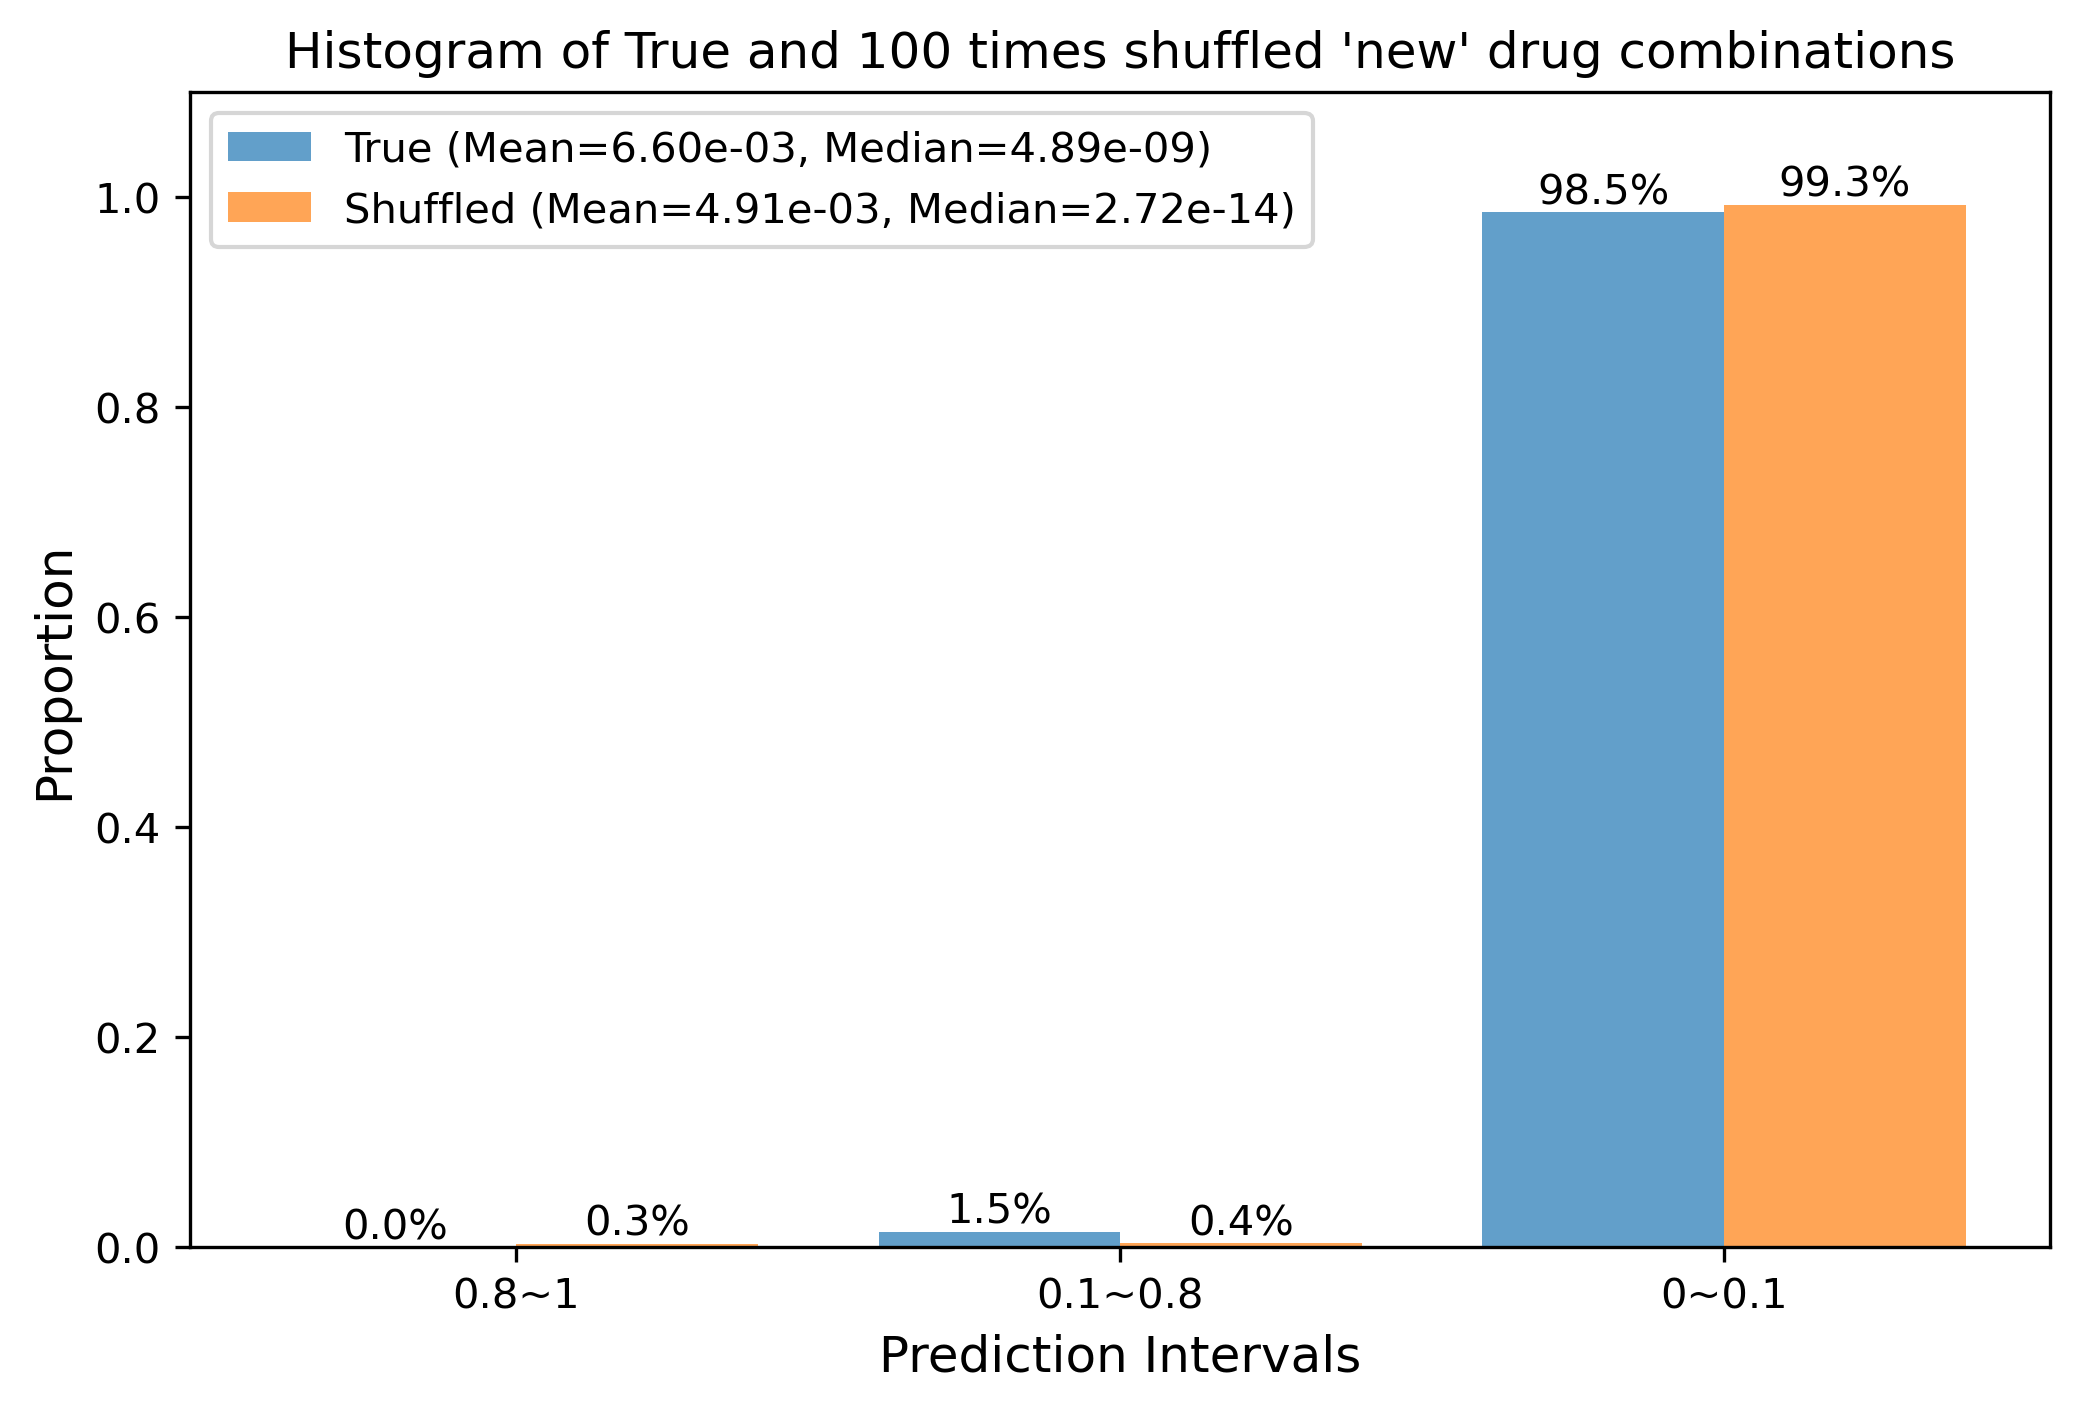

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define bins in increasing order
bins = [0, 0.1, 0.8, 1]

# Compute histograms
true_hist, _ = np.histogram(true_ps_list, bins=bins)
shuffled_hist, _ = np.histogram(shuffled_ps_list_view, bins=bins)

# Convert counts to proportions
true_proportion = true_hist / np.sum(true_hist)  # Normalize to sum to 1
shuffled_proportion = shuffled_hist / np.sum(shuffled_hist)  # Normalize to sum to 1

# Reorder the data for display (0.1~1 first)
true_proportion = true_proportion[::-1]
shuffled_proportion = shuffled_proportion[::-1]

# Set bar positions
x_positions = np.arange(len(bins) - 1)  # Number of bins

# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

# Plot histograms with proportions
bar_width = 0.4
bars1 = ax.bar(x_positions - bar_width/2, true_proportion, width=bar_width, 
               label=f"True (Mean={np.mean(true_ps_list):.2e}, Median={np.median(true_ps_list):.2e})", alpha=0.7)
bars2 = ax.bar(x_positions + bar_width/2, shuffled_proportion, width=bar_width, 
               label=f"Shuffled (Mean={shuffled_ps_mean:.2e}, Median={shuffled_ps_median:.2e})", alpha=0.7)

# Annotate bars with proportions as percentages
for bar, proportion in zip(bars1, true_proportion):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{proportion*100:.1f}%", ha='center', va='bottom')

for bar, proportion in zip(bars2, shuffled_proportion):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{proportion*100:.1f}%", ha='center', va='bottom')

# Set x-ticks and labels with reordered categories
bin_labels = ["0.8~1", "0.1~0.8", "0~0.1"]
ax.set_xticks(x_positions)
ax.set_xticklabels(bin_labels)

ax.set_ylim(0, 1.1)

# Labels and title
ax.set_xlabel("Prediction Intervals", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)
ax.set_title(f"Histogram of True and {n_permu} times shuffled 'new' drug combinations", fontsize=12)
ax.legend()

# Show plot
plt.show()


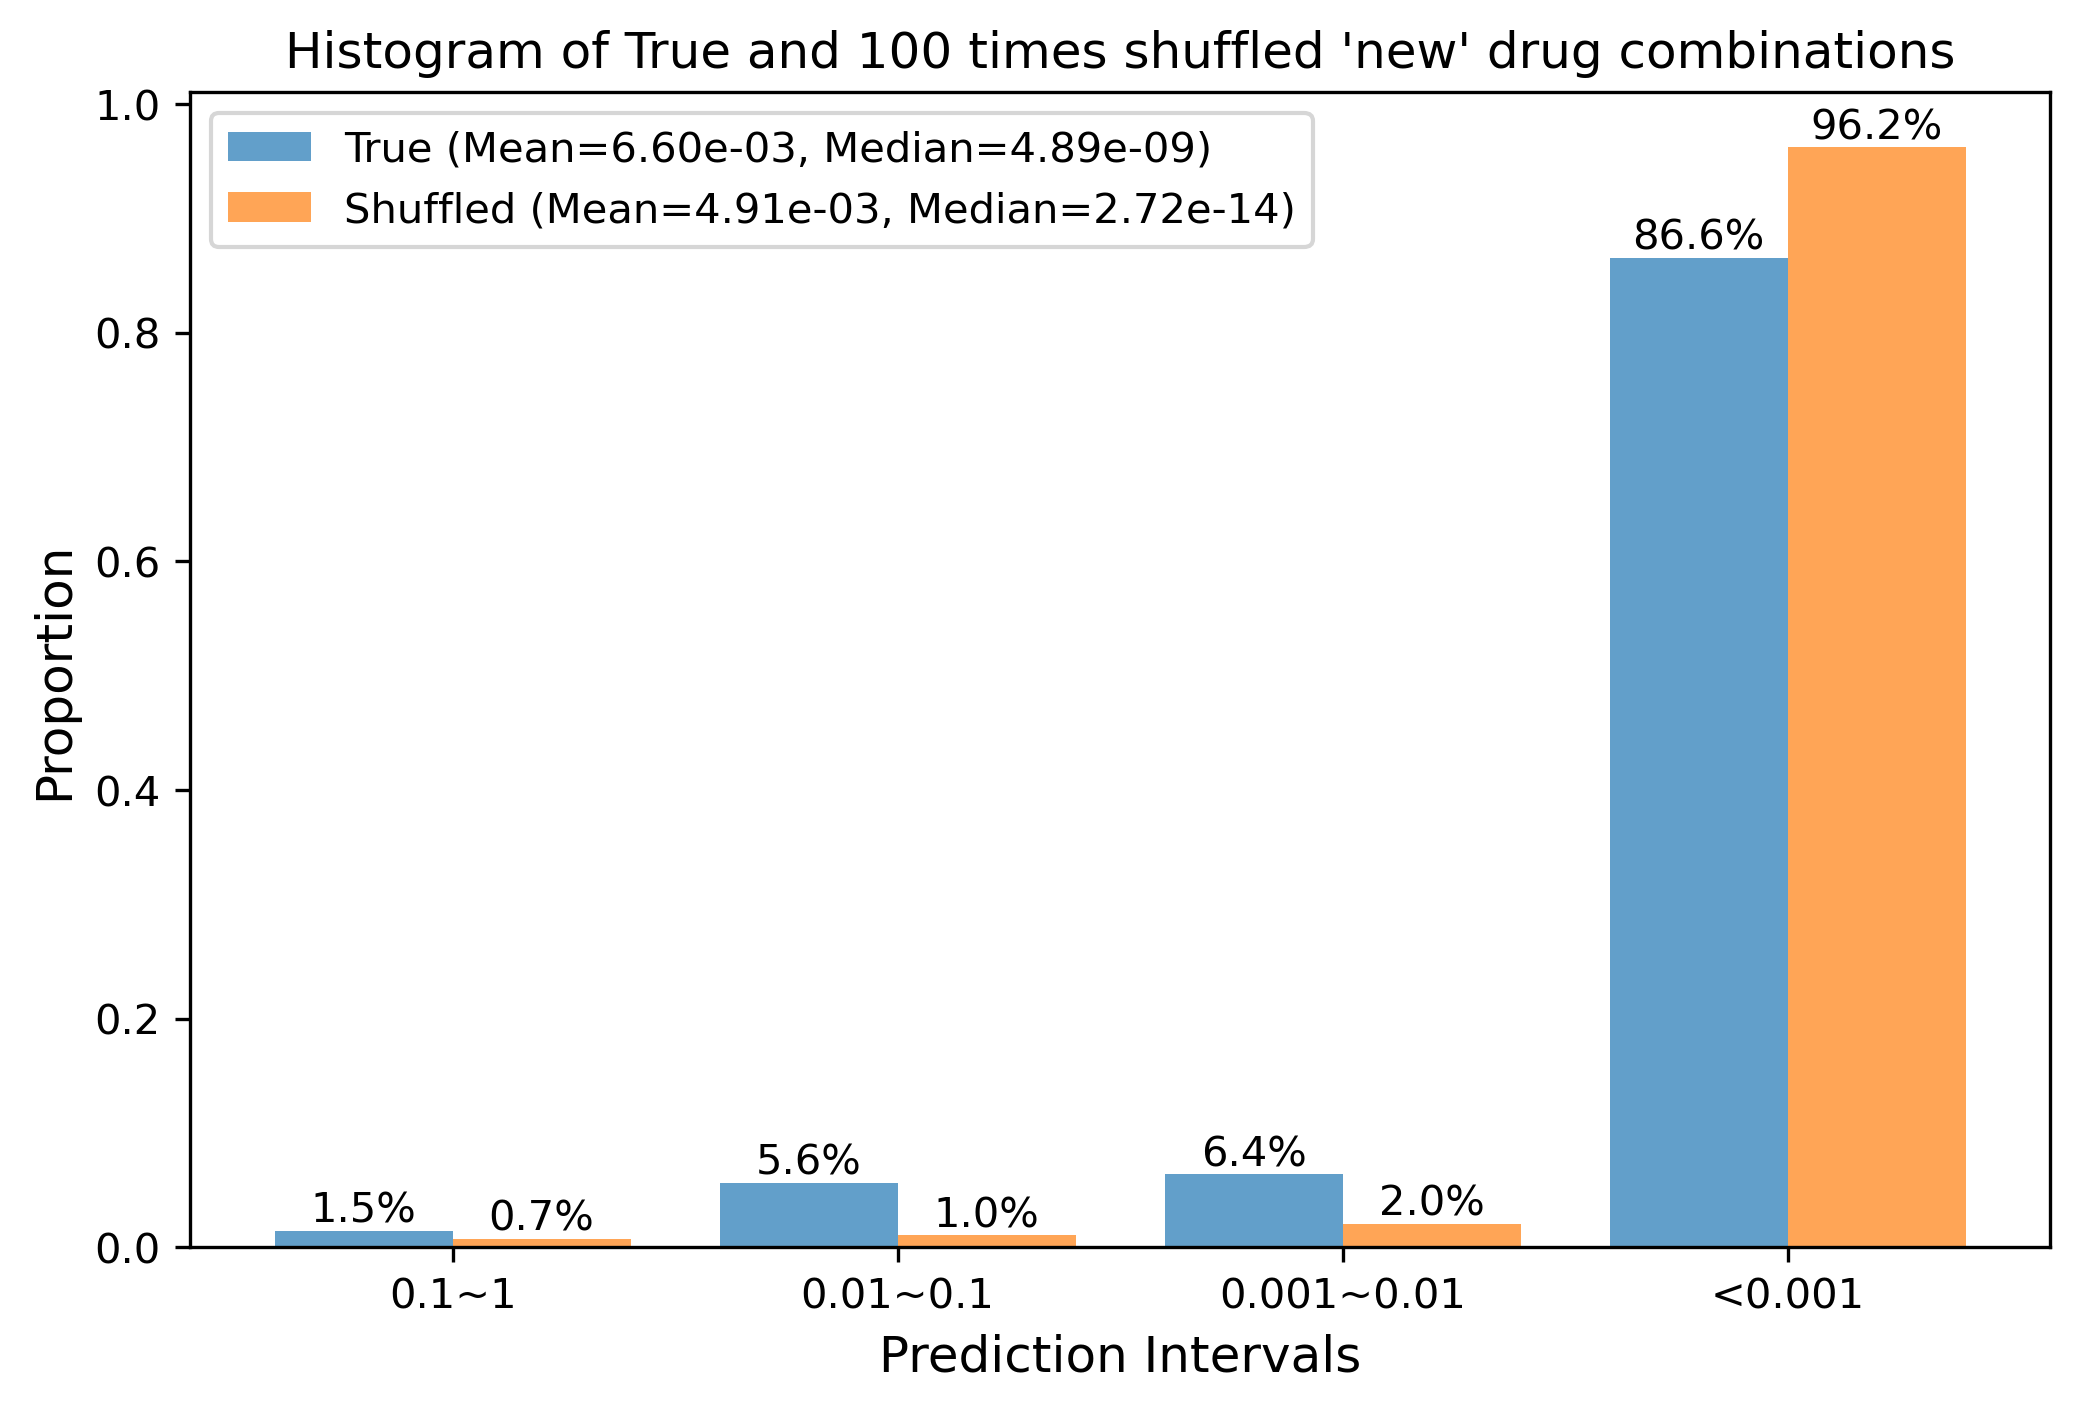

In [11]:
# Define bins in increasing order
bins = [0, 0.001, 0.01, 0.1, 1]

# Compute histograms
true_hist, _ = np.histogram(true_ps_list, bins=bins)
shuffled_hist, _ = np.histogram(shuffled_ps_list_view, bins=bins)

# Convert counts to proportions
true_proportion = true_hist / np.sum(true_hist)  # Normalize to sum to 1
shuffled_proportion = shuffled_hist / np.sum(shuffled_hist)  # Normalize to sum to 1

# Reorder the data for display (0.1~1 first)
true_proportion = true_proportion[::-1]
shuffled_proportion = shuffled_proportion[::-1]

# Set bar positions
x_positions = np.arange(len(bins) - 1)  # Number of bins

# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

# Plot histograms with proportions
bar_width = 0.4
bars1 = ax.bar(x_positions - bar_width/2, true_proportion, width=bar_width, 
               label=f"True (Mean={np.mean(true_ps_list):.2e}, Median={np.median(true_ps_list):.2e})", alpha=0.7)
bars2 = ax.bar(x_positions + bar_width/2, shuffled_proportion, width=bar_width, 
               label=f"Shuffled (Mean={shuffled_ps_mean:.2e}, Median={shuffled_ps_median:.2e})", alpha=0.7)

# Annotate bars with proportions as percentages
for bar, proportion in zip(bars1, true_proportion):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{proportion*100:.1f}%", ha='center', va='bottom')

for bar, proportion in zip(bars2, shuffled_proportion):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{proportion*100:.1f}%", ha='center', va='bottom')

# Set x-ticks and labels with reordered categories
bin_labels = ["0.1~1", "0.01~0.1", "0.001~0.01", "<0.001"]
ax.set_xticks(x_positions)
ax.set_xticklabels(bin_labels)

# Labels and title
ax.set_xlabel("Prediction Intervals", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)
ax.set_title(f"Histogram of True and {n_permu} times shuffled 'new' drug combinations", fontsize=12)
ax.legend()

# Show plot
plt.show()


### evaluation 2: Predicted condition v.s. real condition for drug combs with NA condition

In [26]:
print(f'Within our {combined_df.shape[0]} 2 drugs+condition cdcdb + AACT triplets:')
existed_dcomb = combined_df[['drug1', 'drug2']]
existed_dcomb = existed_dcomb.drop_duplicates().reset_index(drop=True)
print(f'  - There are {existed_dcomb.shape[0]} unique 2-drug combinations')

print(f'Within those {cdcdb_comb_df2_dcomb.shape[0]} unique drug combinations (2 drugs but no condition):')
common_dcomb = cdcdb_comb_df2_dcomb[cdcdb_comb_df2_dcomb.apply(tuple, axis=1).isin(existed_dcomb.apply(tuple, axis=1))].reset_index(drop=True)
new_dcomb = cdcdb_comb_df2_dcomb[~cdcdb_comb_df2_dcomb.apply(tuple, axis=1).isin(existed_dcomb.apply(tuple, axis=1))].reset_index(drop=True)
print(f'  - {common_dcomb.shape[0]} of them are known to be the drug combinations in our cdcdb + AACT triplets')
print(f'  - {new_dcomb.shape[0]} of them are brand "new" drug combinations to us')

# mapped drugs and conditions to index
new_dcomb['drug1_idx'] = new_dcomb['drug1'].map(emb_id_mapping)
new_dcomb['drug2_idx'] = new_dcomb['drug2'].map(emb_id_mapping)

Within our 40205 2 drugs+condition cdcdb + AACT triplets:
  - There are 3150 unique 2-drug combinations
Within those 3563 unique drug combinations (2 drugs but no condition):
  - 1086 of them are known to be the drug combinations in our cdcdb + AACT triplets
  - 2477 of them are brand "new" drug combinations to us


In [17]:
def find_apply_condition(drug1_name, drug2_name):
    drug1_idx = emb_id_mapping[drug1_name]
    drug2_idx = emb_id_mapping[drug2_name]
    
    # find info
    unique_cond_list = sorted(list(set(drug_cond_df['condition'].tolist())))
    cond_idx_list = [emb_id_mapping[cond] for cond in unique_cond_list]
    n_cond = len(cond_idx_list)
    
    # tile the drug lists
    drug_list1 = np.repeat(np.array(drug1_idx), n_cond)
    drug_list2 = np.repeat(np.array(drug2_idx), n_cond)
    
    # run the model
    pred = test_model.forward(drug_list1, drug_list2, cond_idx_list)
    pred_list = np.atleast_1d(pred.detach().cpu().numpy())
    
    # find the top 3 predictions
    top_indices = np.argsort(pred_list)[-5:][::-1]  # get indices of top 3 predictions in descending order
    
    top_preds = []
    for idx in top_indices:
        pred_score = pred_list[idx]
        pred_cond_idx = cond_idx_list[idx]
        pred_cond_name = unique_cond_list[idx]
        top_preds.append((pred_score, pred_cond_idx, pred_cond_name))
    
    return top_preds

In [19]:
find_apply_condition('DB01229', 'DB01254')

[(0.76505727, 1895, 'D009369'),
 (0.34806174, 2714, 'D009371'),
 (0.13712615, 4968, 'D009370'),
 (0.067084305, 2564, 'D012871'),
 (0.054565724, 3448, 'D001941')]

In [ ]:
DB00990	Exemestane	DB00399

In [28]:
new_dcomb

,drug1,drug2,drug1_idx,drug2_idx
0,DB00688,DB06681,222,27
1,DB00188,DB00526,90,201
2,DB00603,DB00624,228,190
3,DB00252,DB00682,725,504
4,DB00588,DB00938,1,167
...,...,...,...,...
2472,DB00652,DB01183,538,393
2473,DB00598,DB00999,149,355
2474,DB01261,DB11827,670,1056
2475,DB00373,DB00999,253,355


In [31]:
# the number of conditions
unique_cond_name_list = sorted(list(set(drug_cond_df['condition'].tolist())))
unique_cond_idx_list = [emb_id_mapping[cond] for cond in unique_cond_name_list]
n_cond = len(unique_cond_idx_list)
# find the potential score and condition for each "new" dcomb
ps_list, pred_cond_idx_list, pred_cond_name_list = [], [], []

drug_list1 = new_dcomb['drug1_idx']
drug_list2 = new_dcomb['drug2_idx']

batch_size = 100
n_batches = int(np.ceil(len(drug_list1) / batch_size))

ps_list = []
pred_cond_idx_list = []

for batch_idx in range(n_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(drug_list1))
    
    # Select current batch
    drug1_batch = np.array(drug_list1[start_idx:end_idx])
    drug2_batch = np.array(drug_list2[start_idx:end_idx])
    
    # Tile condition indices
    cond_list_long = np.tile(unique_cond_idx_list, len(drug1_batch))
    drug1_long = np.repeat(drug1_batch, n_cond)
    drug2_long = np.repeat(drug2_batch, n_cond)
    
    # Forward pass
    pred = test_model.forward(drug1_long, drug2_long, cond_list_long)
    pred_list_batch = np.atleast_1d(pred.detach().cpu().numpy())
    
    # Get max prediction for each drug pair
    for i in range(len(drug1_batch)):
        pred_sublist = pred_list_batch[(i * n_cond):((i + 1) * n_cond)]
        ps = max(pred_sublist)
        ps_pos = np.argmax(pred_sublist)
        cond_idx = unique_cond_idx_list[ps_pos]
        cond_name = unique_cond_name_list[ps_pos]
        ps_list.append(ps)
        pred_cond_idx_list.append(cond_idx)
        pred_cond_name_list.append(cond_name)
        
# add the result to the new_dcomb
new_dcomb_w_pred_cond = new_dcomb.copy()
new_dcomb_w_pred_cond['ps'] = ps_list
new_dcomb_w_pred_cond['pred_cond_idx'] = pred_cond_idx_list
new_dcomb_w_pred_cond['pred_cond'] = pred_cond_name_list
# sorted based on potential score
new_dcomb_w_pred_cond_sorted = new_dcomb_w_pred_cond.sort_values(by='ps', ascending=False).reset_index(drop=True)


In [32]:
find_apply_condition('DB08933', 'DB14512')

[(0.0, 5121, 'D000006'), (0.0, 4684, 'Q000506'), (0.0, 3981, 'D066253')]

In [33]:
new_dcomb_w_pred_cond_sorted[:10]

,drug1,drug2,drug1_idx,drug2_idx,ps,pred_cond_idx,pred_cond
0,DB00112,DB09073,235,322,0.791078,1895,D009369
1,DB00072,DB00112,379,235,0.775772,1895,D009369
2,DB01229,DB01254,80,572,0.765057,1895,D009369
3,DB00398,DB01259,352,184,0.743357,1895,D009369
4,DB00958,DB01101,10,45,0.737613,1895,D009369
5,DB00615,DB00951,300,449,0.698732,2415,D016908
6,DB08881,DB08911,840,585,0.628951,1895,D009369
7,DB00377,DB00904,174,262,0.627056,1895,D009369
8,DB00619,DB00877,69,59,0.338654,1895,D009369
9,DB00182,DB01255,35,860,0.326372,4914,D065886


## All the predicted triplets with predicted scores passing threshold & top3 prediction per condition

In [31]:
lr = 0.001
epoch = 500
MLP_hl1_size = 512
MLP_hl2_size = 128
dropout = 0.5
batch_size = 2048
multi = 100
seed = 2024
train_partition = 0.8
test_partition = 0.1
sampling_ratio = 0.8
model_name = 'MLP_avg_effect'


#####-----trained model loading-----#####
# read the saved model
model_name = model_name
save_dir = save_dir
m_name = f'DCP_{model_name}_{lr}_{epoch}_{MLP_hl1_size}_{MLP_hl2_size}_{dropout}_{batch_size}_{multi}_{seed}_{train_partition}_{test_partition}_{sampling_ratio}_architecture_after_finetuning.pth'
w_name = f'DCP_{model_name}_{lr}_{epoch}_{MLP_hl1_size}_{MLP_hl2_size}_{dropout}_{batch_size}_{multi}_{seed}_{train_partition}_{test_partition}_{sampling_ratio}_weights_after_finetuning.pth'
final_model = torch.load(save_dir + m_name)
final_model.load_state_dict(torch.load(save_dir + w_name))
final_model.eval()


#####-----find all predictions passing the threshold 0.1-----#####
switch = True
if switch:
    # find all the drug idx and condition idx
    all_unique_drug_idx_list = sorted(set(drug_cond_df['drug_idx'].tolist()))
    all_unique_cond_idx_list = sorted(set(drug_cond_df['cond_idx'].tolist()))

    # set a threshold
    pred_thred = 0.1
    # these are the predicted triplets that pass the threshold
    threshold_triplets, threshold_triplets_scores = [], []
    # List to store top 3 triplets and their scores for each condition
    top_3_triplets, top_3_triplets_scores = [], []
    
    # Convert all_comb_triplets to a set for faster membership checking
    all_comb_triplets_set = set(map(tuple, all_comb_triplets))
    # record the time
    start_time = time.time()
    
    # iteration to find predictions with predicted scores greater than the threshold
    for cond_idx in all_unique_cond_idx_list[:2]:
        tmp_triplets1 = [[x, y, cond_idx] for x, y in itertools.combinations(all_unique_drug_idx_list, 2)]
        # filter out existing triplets
        triplets = [triplet for triplet in tmp_triplets1 if tuple(triplet) not in all_comb_triplets_set]
        
        # run the model
        drug_list1, drug_list2, cond_list = np.array(triplets).T
        pred = final_model.forward(drug_list1, drug_list2, cond_list)
        pred = np.array(pred.detach().numpy())

        filtered_triplets = [(triplet, p) for triplet, p in zip(triplets, pred) if p > pred_thred]
        if filtered_triplets:
            threshold_triplets_pass, threshold_triplets_scores_pass = zip(*filtered_triplets)
            threshold_triplets_pass = list(threshold_triplets_pass)
            threshold_triplets_scores_pass = list(threshold_triplets_scores_pass)
            
            # Sort before appending
            sorted_pass_pairs = sorted(zip(threshold_triplets_pass, threshold_triplets_scores_pass), key=lambda x: x[1], reverse=True)
            threshold_triplets_pass, threshold_triplets_scores_pass = zip(*sorted_pass_pairs)
            threshold_triplets_pass = list(threshold_triplets_pass)
            threshold_triplets_scores_pass = list(threshold_triplets_scores_pass)
            
            # Append the results
            threshold_triplets = threshold_triplets + threshold_triplets_pass
            threshold_triplets_scores = threshold_triplets_scores + threshold_triplets_scores_pass
        
            # Sort triplets by predicted scores in descending order and get the top 3
            top_3_triplets_for_cond = sorted(zip(threshold_triplets_pass, threshold_triplets_scores_pass),
                                             key=lambda x: x[1], reverse=True)[:3]
            
            # Record the top 3 triplets and their scores for the current condition
            for triplet, score in top_3_triplets_for_cond:
                top_3_triplets.append(triplet)
                top_3_triplets_scores.append(score)

        # print the running time
        now_time = time.time()
        total_time = now_time - start_time
        print('Running time: {:.2f} seconds'.format(total_time))

    ### map the idx to the names
    # top 3 triplets matrix
    drug1_list, drug2_list, cond_list = np.array(top_3_triplets).T
    data = {
        'drug1_idx': drug1_list,
        'drug2_idx': drug2_list,
        'cond_idx': cond_list,
        'scores': top_3_triplets_scores
    }
    df = pd.DataFrame(data)
    df['drug1'] = [name for idx in drug1_list for name, value in emb_id_mapping.items() if idx==value]
    df['drug2'] = [name for idx in drug2_list for name, value in emb_id_mapping.items() if idx==value]
    df['condition'] = [name for idx in cond_list for name, value in emb_id_mapping.items() if idx==value]
    top_3_df = df[['drug1', 'drug2', 'condition', 'scores']]
    
    # triplets that pass the threshold
    drug1_list, drug2_list, cond_list = np.array(threshold_triplets).T
    data = {
        'drug1_idx': drug1_list,
        'drug2_idx': drug2_list,
        'cond_idx': cond_list,
        'scores': threshold_triplets_scores
    }
    df = pd.DataFrame(data)
    df['drug1'] = [name for idx in drug1_list for name, value in emb_id_mapping.items() if idx==value]
    df['drug2'] = [name for idx in drug2_list for name, value in emb_id_mapping.items() if idx==value]
    df['condition'] = [name for idx in cond_list for name, value in emb_id_mapping.items() if idx==value]
    pass_threshold_df = df[['drug1', 'drug2', 'condition', 'scores']]

    # filename1 = 'top_3_triplets_per_condition.csv'
    # top_3_df.to_csv(save_dir+filename1)
    # filename2 = 'triplets_pass_threshold.csv'
    # pass_threshold_df.to_csv(save_dir+filename2)

Running time: 63.96 seconds
Running time: 129.85 seconds


In [6]:
top_3_df

,drug1,drug2,condition,scores
0,DB11595,DB11800,D002292,0.468133
1,DB00877,DB00688,D002292,0.465952
2,DB09078,DB00643,D002292,0.416647
3,DB00947,DB01217,D009362,0.743540
4,DB00650,DB00563,D009362,0.653294
5,DB00544,DB00762,D009362,0.649111


In [32]:
pass_threshold_df

,drug1,drug2,condition,scores
0,DB11595,DB11800,D002292,0.468133
1,DB00877,DB00688,D002292,0.465952
2,DB09078,DB00643,D002292,0.416647
3,DB01229,DB04868,D002292,0.382379
4,DB00958,DB00773,D002292,0.360051
...,...,...,...,...
140,DB11714,DB00002,D009362,0.106095
141,DB01229,DB00480,D009362,0.105109
142,DB00531,DB09037,D009362,0.103960
143,DB01229,DB00227,D009362,0.102457


## Find the candidate second drugs

In [30]:
switch = True
if switch:
    # find all the drug idx and condition idx
    all_unique_drug_idx_list = sorted(set(drug_cond_df['drug_idx'].tolist()))
    all_unique_cond_idx_list = sorted(set(drug_cond_df['cond_idx'].tolist()))
    
    def find_second_drug(drug_idx, cond_idx, threshold):
        df_sub = combined_df[combined_df['cond_idx']==cond_idx]
        drug_list = list(df_sub['drug1']) + list(df_sub['drug2'])
        top_preds = []
        # if this drug never present in any drug combination
        if len(drug_list)==0 or drug_idx not in drug_list:
            other_drug_list = [i for i in all_unique_drug_idx_list if i!=drug_idx]
            drug_idx_list = list(np.repeat(drug_idx, len(other_drug_list)))
            cond_idx_list = list(np.repeat(cond_idx, len(other_drug_list)))
            pred = final_model.forward(other_drug_list, drug_idx_list, cond_idx_list)
            pred_list = np.array(pred.detach().numpy())
            # we find the candidate second drugs
            # find the top 3 predictions
            top3_indices = np.argsort(pred_list)[-3:][::-1]
            for idx in top3_indices:
                pred_score = pred_list[idx]
                if pred_score > 0.1:
                    candidate_drug_idx = other_drug_list[idx]
                    top_preds.append((drug_idx, candidate_drug_idx, cond_idx, pred_score))
        
        return top_preds
    
    threshold = 0.1
    count = 0
    second_drug_propose_list = []
    for i in range(drug_cond_df[:100].shape[0]):
        drug_idx = drug_cond_df['drug_idx'][i]
        cond_idx = drug_cond_df['cond_idx'][i]
        results = find_second_drug(drug_idx, cond_idx, threshold)
        if len(results)!=0:
            count += 1
            for r in results:
                second_drug_propose_list.append(list(r))
    
    print(f"Among {drug_cond_df[:100].shape[0]} clinical trials:")
    print(f"  - {count} of them don't exist in any cdcdb triplets")
    
    drug1_list, drug2_list, cond_list, score_list = np.array(second_drug_propose_list).T
    data = {
        'drug1_idx': drug1_list,
        'drug2_idx': drug2_list,
        'cond_idx': cond_list,
        'scores': score_list
    }
    df = pd.DataFrame(data)
    df['drug1'] = [name for idx in drug1_list for name, value in emb_id_mapping.items() if idx==value]
    df['drug2'] = [name for idx in drug2_list for name, value in emb_id_mapping.items() if idx==value]
    df['condition'] = [name for idx in cond_list for name, value in emb_id_mapping.items() if idx==value]
    second_drug_df = df[['drug1', 'drug2', 'condition', 'scores']]
    
    # filename3 = 'clinical_trials_with_proposed_second_drugs.csv'
    # top_3_df.to_csv(save_dir+filename3)

Among 100 clinical trials:
  - 43 of them don't exist in any cdcdb triplets


In [29]:
second_drug_df

,drug1,drug2,condition,scores
0,DB11595,DB00220,D002292,0.804425
1,DB11595,DB00112,D002292,0.772472
2,DB11595,DB09035,D002292,0.670993
3,DB11595,DB00112,D009362,0.621480
4,DB11595,DB00112,D007680,0.824108
...,...,...,...,...
92,DB09035,DB14851,D000077195,0.984852
93,DB09035,DB06186,D000077195,0.953980
94,DB09035,DB00515,D000077195,0.809883
95,DB06186,DB09035,D006258,0.843413


## Oncodrug triplets analysis

In [5]:
# read the Oncodrug clean csv file
Onco_A = pd.read_csv(Onco_dir+'Onco_A_clean.csv')
# read the Oncodrug clean csv file
Onco_B = pd.read_csv(Onco_dir+'Onco_B_clean.csv')
# read the Oncodrug clean csv file
Onco_C = pd.read_csv(Onco_dir+'Onco_C_clean.csv')
# read the Oncodrug clean csv file
Onco_D = pd.read_csv(Onco_dir+'Onco_D_clean.csv')

# find the union of conditions from Oncodrug
dfs = [Onco_A, Onco_B, Onco_C, Onco_D]
union_condition_ids = set().union(*(df['condition_id'].tolist() for df in dfs))

# find the conditions included in our study
Onco_cond_list = sorted(list(union_condition_ids & set(drug_cond_df['condition'].tolist())))
Onco_cond_idx_list = [emb_id_mapping.get(x) for x in Onco_cond_list]
print(f'There are {len(Onco_cond_list)} Oncodrug conditions that are included in our study')

There are 68 Oncodrug conditions that are included in our study


#### Level A

In [6]:
print('For Oncodrug Level A:')
print(f'- Before removing duplicated rows, there are {Onco_A.shape[0]} triplets included in our study')
Onco_A[['drug1_id', 'drug2_id']] = (
    Onco_A[['drug1_id', 'drug2_id']]
    .apply(lambda x: pd.Series(sorted(x)), axis=1))
Onco_A = Onco_A.drop_duplicates().reset_index(drop=True)
print(f'- After removing duplicated rows, there are {Onco_A.shape[0]} triplets included in our study\n')

# find the triplets where both drugs and condition are also in our study
print(f'There are {Onco_A.shape[0]} clean triplets from Oncodrug Level A xlsx')
pick_row = [i for i in range(Onco_A.shape[0]) if 
            Onco_A['drug1_id'][i] in drug_cond_df['drug'].tolist() and 
            Onco_A['drug2_id'][i] in drug_cond_df['drug'].tolist() and 
            Onco_A['condition_id'][i] in drug_cond_df['condition'].tolist()]
Onco_A = Onco_A.iloc[pick_row,:].reset_index(drop=True)
print(f'  - {Onco_A.shape[0]} of them have both drugs and condition included in our study')

# only include unknown drug combination in the following analysis
onco_pairs = [tuple(sorted((d1, d2))) 
              for d1, d2 in zip(Onco_A["drug1_id"], Onco_A["drug2_id"])]
combined_pairs = {tuple(sorted((d1, d2)))
                  for d1, d2 in zip(combined_df["drug1"], combined_df["drug2"])}
mask = [pair not in combined_pairs for pair in onco_pairs]
Onco_A = Onco_A[mask].reset_index(drop=True)
print(f'  - {Onco_A.shape[0]} of them left after filtering out known drug combinations\n')

# map the drug id and condition id to the idx
Onco_A['drug1_idx'] = Onco_A['drug1_id'].map(emb_id_mapping)
Onco_A['drug2_idx'] = Onco_A['drug2_id'].map(emb_id_mapping)
Onco_A['cond_idx'] = Onco_A['condition_id'].map(emb_id_mapping)


### find the rank
real_pred_list, rank_list = [], []
# iterate over clean triplets from Oncodrug Level B matrix
for i in range(Onco_A.shape[0]):
    drug1 = Onco_A['drug1_idx'][i]
    drug2 = Onco_A['drug2_idx'][i]
    cond = Onco_A['cond_idx'][i]
    drug_list1 = np.repeat(drug1, len(Onco_cond_idx_list))
    drug_list2 = np.repeat(drug2, len(Onco_cond_idx_list))
    # run the model
    pred = test_model.forward(drug_list1, drug_list2, Onco_cond_idx_list)
    pred_list = np.atleast_1d(pred.detach().cpu().numpy()).tolist()
    idx = Onco_cond_idx_list.index(cond)
    # find the prediction and its rank for the actual condition
    real_pred = pred_list[idx]
    arr = np.array(pred_list)
    rank = arr.argsort()[::-1].tolist().index(list(arr).index(real_pred)) + 1
    # append the result
    real_pred_list.append(real_pred)
    rank_list.append(rank)

# add to the dataframe
Onco_A["score"] = real_pred_list
Onco_A["rank"] = rank_list

top1_freq = Onco_A["rank"].isin([1]).sum()
print(f"Total frequency in top 1 rank: {top1_freq}, percentage: {(top1_freq*100/Onco_A.shape[0]):.2f}%")
top3_freq = Onco_A["rank"].isin([1, 2, 3]).sum()
print(f"Total frequency in top 3 ranks: {top3_freq}, percentage: {(top3_freq*100/Onco_A.shape[0]):.2f}%")

For Oncodrug Level A:
- Before removing duplicated rows, there are 57 triplets included in our study
- After removing duplicated rows, there are 44 triplets included in our study

There are 44 clean triplets from Oncodrug Level A xlsx
  - 36 of them have both drugs and condition included in our study
  - 9 of them left after filtering out known drug combinations

Total frequency in top 1 rank: 1, percentage: 11.11%
Total frequency in top 3 ranks: 3, percentage: 33.33%


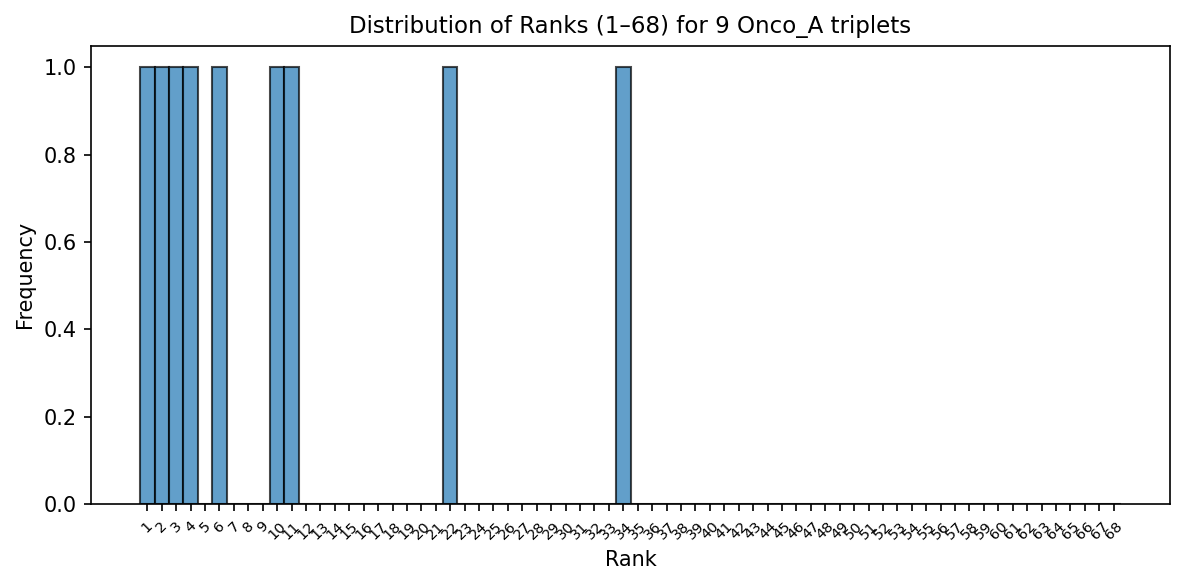

In [7]:
plt.figure(figsize=(8, 4), dpi=150)

# Histogram with bins
plt.hist(Onco_A["rank"], bins=range(1, len(Onco_cond_list)+2), edgecolor="black", alpha=0.7)

plt.xlabel("Rank", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.title(f"Distribution of Ranks (1–{len(Onco_cond_list)}) for {Onco_A.shape[0]} Onco_A triplets", fontsize=11)

# Put ticks at bin centers
centers = [i + 0.5 for i in range(1, len(Onco_cond_list)+1)]
plt.xticks(centers, labels=range(1, len(Onco_cond_list)+1), fontsize=7, rotation=45)

plt.tight_layout()
plt.show()


#### Level B

In [8]:
print('For Oncodrug Level B:')
print(f'- Before removing duplicated rows, there are {Onco_B.shape[0]} triplets included in our study')
Onco_B[['drug1_id', 'drug2_id']] = (
    Onco_B[['drug1_id', 'drug2_id']]
    .apply(lambda x: pd.Series(sorted(x)), axis=1))
Onco_B = Onco_B.drop_duplicates().reset_index(drop=True)
print(f'- After removing duplicated rows, there are {Onco_B.shape[0]} triplets included in our study\n')

print(f'There are {len(Onco_cond_list)} Oncodrug conditions that are included in our study')
# find the triplets where both drugs and condition are also in our study
print(f'There are {Onco_B.shape[0]} clean triplets from Oncodrug Level B xlsx')
pick_row = [i for i in range(Onco_B.shape[0]) if 
            Onco_B['drug1_id'][i] in drug_cond_df['drug'].tolist() and 
            Onco_B['drug2_id'][i] in drug_cond_df['drug'].tolist() and 
            Onco_B['condition_id'][i] in drug_cond_df['condition'].tolist()]
Onco_B = Onco_B.iloc[pick_row,:].reset_index(drop=True)
print(f'  - {Onco_B.shape[0]} of them have both drugs and condition included in our study')

# only include unknown drug combination in the following analysis
onco_pairs = [tuple(sorted((d1, d2))) 
              for d1, d2 in zip(Onco_B["drug1_id"], Onco_B["drug2_id"])]
combined_pairs = {tuple(sorted((d1, d2)))
                  for d1, d2 in zip(combined_df["drug1"], combined_df["drug2"])}
mask = [pair not in combined_pairs for pair in onco_pairs]
Onco_B = Onco_B[mask].reset_index(drop=True)
print(f'  - {Onco_B.shape[0]} of them left after filtering out known drug combinations\n')

# map the drug id and condition id to the idx
Onco_B['drug1_idx'] = Onco_B['drug1_id'].map(emb_id_mapping)
Onco_B['drug2_idx'] = Onco_B['drug2_id'].map(emb_id_mapping)
Onco_B['cond_idx'] = Onco_B['condition_id'].map(emb_id_mapping)


### find the rank
real_pred_list, rank_list = [], []
# iterate over clean triplets from Oncodrug Level B matrix
for i in range(Onco_B.shape[0]):
    drug1 = Onco_B['drug1_idx'][i]
    drug2 = Onco_B['drug2_idx'][i]
    cond = Onco_B['cond_idx'][i]
    drug_list1 = np.repeat(drug1, len(Onco_cond_idx_list))
    drug_list2 = np.repeat(drug2, len(Onco_cond_idx_list))
    # run the model
    pred = test_model.forward(drug_list1, drug_list2, Onco_cond_idx_list)
    pred_list = np.atleast_1d(pred.detach().cpu().numpy()).tolist()
    idx = Onco_cond_idx_list.index(cond)
    # find the prediction and its rank for the actual condition
    real_pred = pred_list[idx]
    arr = np.array(pred_list)
    rank = arr.argsort()[::-1].tolist().index(list(arr).index(real_pred)) + 1
    # append the result
    real_pred_list.append(real_pred)
    rank_list.append(rank)

# add to the dataframe
Onco_B["score"] = real_pred_list
Onco_B["rank"] = rank_list

top1_freq = Onco_B["rank"].isin([1]).sum()
print(f"Total frequency in top 1 rank: {top1_freq}, percentage: {(top1_freq*100/Onco_B.shape[0]):.2f}%")
top3_freq = Onco_B["rank"].isin([1, 2, 3]).sum()
print(f"Total frequency in top 3 ranks: {top3_freq}, percentage: {(top3_freq*100/Onco_B.shape[0]):.2f}%")

For Oncodrug Level B:
- Before removing duplicated rows, there are 717 triplets included in our study
- After removing duplicated rows, there are 447 triplets included in our study

There are 68 Oncodrug conditions that are included in our study
There are 447 clean triplets from Oncodrug Level B xlsx
  - 295 of them have both drugs and condition included in our study
  - 69 of them left after filtering out known drug combinations

Total frequency in top 1 rank: 15, percentage: 21.74%
Total frequency in top 3 ranks: 26, percentage: 37.68%


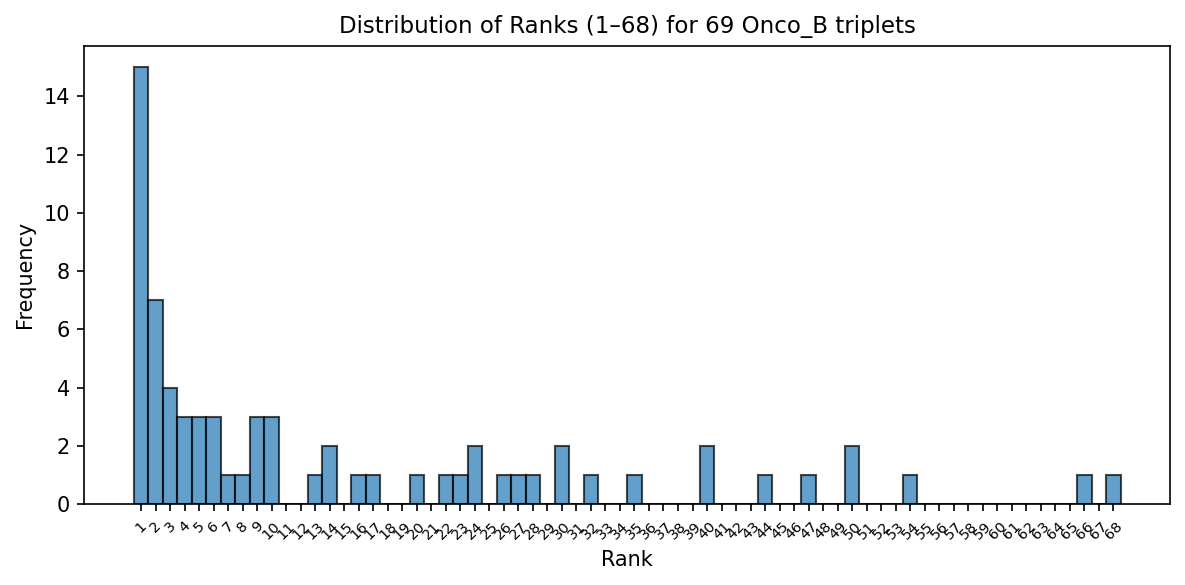

In [9]:
plt.figure(figsize=(8, 4), dpi=150)

# Histogram with bins from 1 to 54 (to cover 1–53 fully)
plt.hist(Onco_B["rank"], bins=range(1, len(Onco_cond_list)+2), edgecolor="black", alpha=0.7)

plt.xlabel("Rank", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.title(f"Distribution of Ranks (1–{len(Onco_cond_list)}) for {Onco_B.shape[0]} Onco_B triplets", fontsize=11)

# Put ticks at bin centers
centers = [i + 0.5 for i in range(1, len(Onco_cond_list)+1)]
plt.xticks(centers, labels=range(1, len(Onco_cond_list)+1), fontsize=7, rotation=45)

plt.tight_layout()
plt.show()


#### Level C

In [10]:
print('For Oncodrug Level C:')
print(f'- Before removing duplicated rows, there are {Onco_C.shape[0]} triplets included in our study')
Onco_C[['drug1_id', 'drug2_id']] = (
    Onco_C[['drug1_id', 'drug2_id']]
    .apply(lambda x: pd.Series(sorted(x)), axis=1))
Onco_C = Onco_C.drop_duplicates().reset_index(drop=True)
print(f'- After removing duplicated rows, there are {Onco_C.shape[0]} triplets included in our study\n')

print(f'There are {len(Onco_cond_list)} Oncodrug conditions that are included in our study')
# find the triplets where both drugs and condition are also in our study
print(f'There are {Onco_C.shape[0]} clean triplets from Oncodrug Level C xlsx')
pick_row = [i for i in range(Onco_C.shape[0]) if 
            Onco_C['drug1_id'][i] in drug_cond_df['drug'].tolist() and 
            Onco_C['drug2_id'][i] in drug_cond_df['drug'].tolist() and 
            Onco_C['condition_id'][i] in drug_cond_df['condition'].tolist()]
Onco_C = Onco_C.iloc[pick_row,:].reset_index(drop=True)
print(f'  - {Onco_C.shape[0]} of them have both drugs and condition included in our study')

# only include unknown drug combination in the following analysis
onco_pairs = [tuple(sorted((d1, d2))) 
              for d1, d2 in zip(Onco_C["drug1_id"], Onco_C["drug2_id"])]
combined_pairs = {tuple(sorted((d1, d2)))
                  for d1, d2 in zip(combined_df["drug1"], combined_df["drug2"])}
mask = [pair not in combined_pairs for pair in onco_pairs]
Onco_C = Onco_C[mask].reset_index(drop=True)
print(f'  - {Onco_C.shape[0]} of them left after filtering out known drug combinations\n')

# map the drug id and condition id to the idx
Onco_C['drug1_idx'] = Onco_C['drug1_id'].map(emb_id_mapping)
Onco_C['drug2_idx'] = Onco_C['drug2_id'].map(emb_id_mapping)
Onco_C['cond_idx'] = Onco_C['condition_id'].map(emb_id_mapping)


### find the rank
real_pred_list, rank_list = [], []
# iterate over clean triplets from Oncodrug Level B matrix
for i in range(Onco_C.shape[0]):
    drug1 = Onco_C['drug1_idx'][i]
    drug2 = Onco_C['drug2_idx'][i]
    cond = Onco_C['cond_idx'][i]
    drug_list1 = np.repeat(drug1, len(Onco_cond_idx_list))
    drug_list2 = np.repeat(drug2, len(Onco_cond_idx_list))
    # run the model
    pred = test_model.forward(drug_list1, drug_list2, Onco_cond_idx_list)
    pred_list = np.atleast_1d(pred.detach().cpu().numpy()).tolist()
    idx = Onco_cond_idx_list.index(cond)
    # find the prediction and its rank for the actual condition
    real_pred = pred_list[idx]
    arr = np.array(pred_list)
    rank = arr.argsort()[::-1].tolist().index(list(arr).index(real_pred)) + 1
    # append the result
    real_pred_list.append(real_pred)
    rank_list.append(rank)

# add to the dataframe
Onco_C["score"] = real_pred_list
Onco_C["rank"] = rank_list

top1_freq = Onco_C["rank"].isin([1]).sum()
print(f"Total frequency in top 1 rank: {top1_freq}, percentage: {(top1_freq*100/Onco_C.shape[0]):.2f}%")
top3_freq = Onco_C["rank"].isin([1, 2, 3]).sum()
print(f"Total frequency in top 3 ranks: {top3_freq}, percentage: {(top3_freq*100/Onco_C.shape[0]):.2f}%")

For Oncodrug Level C:
- Before removing duplicated rows, there are 721 triplets included in our study
- After removing duplicated rows, there are 433 triplets included in our study

There are 68 Oncodrug conditions that are included in our study
There are 433 clean triplets from Oncodrug Level C xlsx
  - 169 of them have both drugs and condition included in our study
  - 121 of them left after filtering out known drug combinations

Total frequency in top 1 rank: 17, percentage: 14.05%
Total frequency in top 3 ranks: 28, percentage: 23.14%


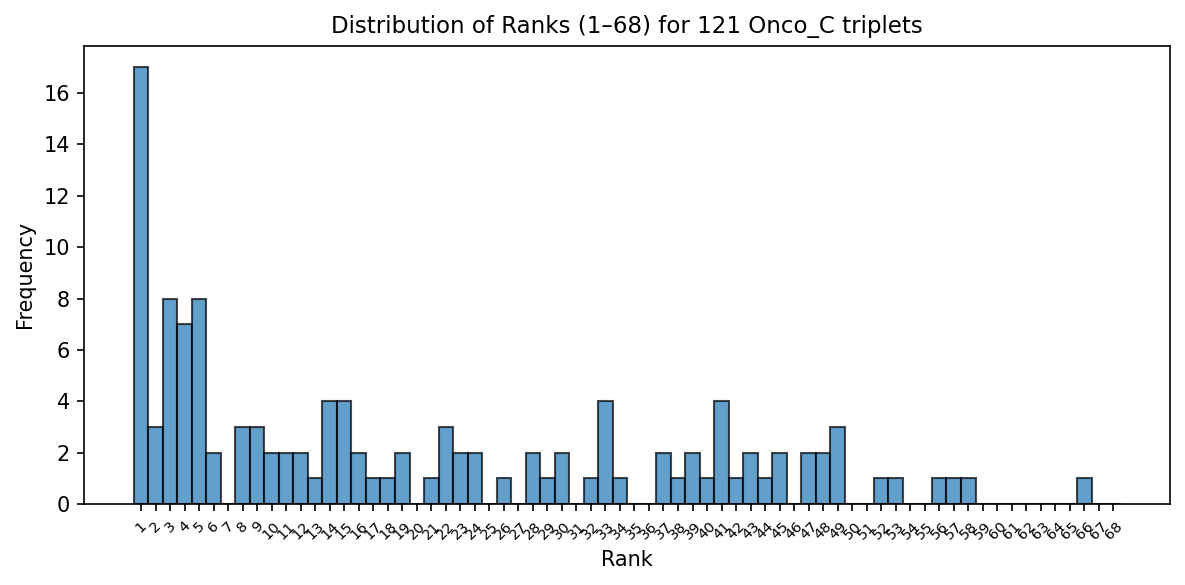

In [11]:
plt.figure(figsize=(8, 4), dpi=150)

# Histogram with bins
plt.hist(Onco_C["rank"], bins=range(1, len(Onco_cond_list)+2), edgecolor="black", alpha=0.7)

plt.xlabel("Rank", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.title(f"Distribution of Ranks (1–{len(Onco_cond_list)}) for {Onco_C.shape[0]} Onco_C triplets", fontsize=11)

# Put ticks at bin centers
centers = [i + 0.5 for i in range(1, len(Onco_cond_list)+1)]
plt.xticks(centers, labels=range(1, len(Onco_cond_list)+1), fontsize=7, rotation=45)

plt.tight_layout()
plt.show()


#### Level D

In [12]:
print('For Oncodrug Level D:')
print(f'- Before removing duplicated rows, there are {Onco_D.shape[0]} triplets included in our study')
Onco_D[['drug1_id', 'drug2_id']] = (
    Onco_D[['drug1_id', 'drug2_id']]
    .apply(lambda x: pd.Series(sorted(x)), axis=1))
Onco_D = Onco_D.drop_duplicates().reset_index(drop=True)
print(f'- After removing duplicated rows, there are {Onco_D.shape[0]} triplets included in our study\n')

print(f'There are {len(Onco_cond_list)} Oncodrug conditions that are included in our study')
# find the triplets where both drugs and condition are also in our study
print(f'There are {Onco_D.shape[0]} clean triplets from Oncodrug Level D xlsx')
pick_row = [i for i in range(Onco_D.shape[0]) if 
            Onco_D['drug1_id'][i] in drug_cond_df['drug'].tolist() and 
            Onco_D['drug2_id'][i] in drug_cond_df['drug'].tolist() and 
            Onco_D['condition_id'][i] in drug_cond_df['condition'].tolist()]
Onco_D = Onco_D.iloc[pick_row,:].reset_index(drop=True)
print(f'  - {Onco_D.shape[0]} of them have both drugs and condition included in our study')

# only include unknown drug combination in the following analysis
onco_pairs = [tuple(sorted((d1, d2))) 
              for d1, d2 in zip(Onco_D["drug1_id"], Onco_D["drug2_id"])]
combined_pairs = {tuple(sorted((d1, d2)))
                  for d1, d2 in zip(combined_df["drug1"], combined_df["drug2"])}
mask = [pair not in combined_pairs for pair in onco_pairs]
Onco_D = Onco_D[mask].reset_index(drop=True)
print(f'  - {Onco_D.shape[0]} of them left after filtering out known drug combinations\n')

# map the drug id and condition id to the idx
Onco_D['drug1_idx'] = Onco_D['drug1_id'].map(emb_id_mapping)
Onco_D['drug2_idx'] = Onco_D['drug2_id'].map(emb_id_mapping)
Onco_D['cond_idx'] = Onco_D['condition_id'].map(emb_id_mapping)


### find the rank
real_pred_list, rank_list = [], []
# iterate over clean triplets from Oncodrug Level B matrix
for i in range(Onco_D.shape[0]):
    drug1 = Onco_D['drug1_idx'][i]
    drug2 = Onco_D['drug2_idx'][i]
    cond = Onco_D['cond_idx'][i]
    drug_list1 = np.repeat(drug1, len(Onco_cond_idx_list))
    drug_list2 = np.repeat(drug2, len(Onco_cond_idx_list))
    # run the model
    pred = test_model.forward(drug_list1, drug_list2, Onco_cond_idx_list)
    pred_list = np.atleast_1d(pred.detach().cpu().numpy()).tolist()
    idx = Onco_cond_idx_list.index(cond)
    # find the prediction and its rank for the actual condition
    real_pred = pred_list[idx]
    arr = np.array(pred_list)
    rank = arr.argsort()[::-1].tolist().index(list(arr).index(real_pred)) + 1
    # append the result
    real_pred_list.append(real_pred)
    rank_list.append(rank)

# add to the dataframe
Onco_D["score"] = real_pred_list
Onco_D["rank"] = rank_list

top1_freq = Onco_D["rank"].isin([1]).sum()
print(f"Total frequency in top 1 rank: {top1_freq}, percentage: {(top1_freq*100/Onco_D.shape[0]):.2f}%")
top3_freq = Onco_D["rank"].isin([1, 2, 3]).sum()
print(f"Total frequency in top 3 ranks: {top3_freq}, percentage: {(top3_freq*100/Onco_D.shape[0]):.2f}%")

For Oncodrug Level D:
- Before removing duplicated rows, there are 4936 triplets included in our study
- After removing duplicated rows, there are 3900 triplets included in our study

There are 68 Oncodrug conditions that are included in our study
There are 3900 clean triplets from Oncodrug Level D xlsx
  - 548 of them have both drugs and condition included in our study
  - 505 of them left after filtering out known drug combinations

Total frequency in top 1 rank: 66, percentage: 13.07%
Total frequency in top 3 ranks: 87, percentage: 17.23%


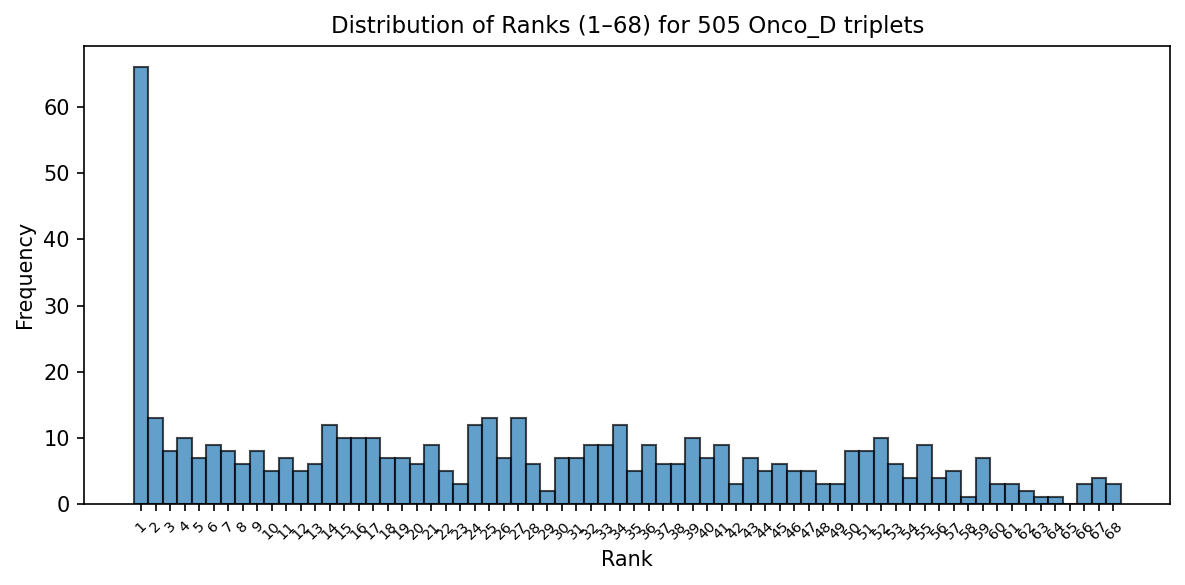

In [13]:
plt.figure(figsize=(8, 4), dpi=150)

# Histogram with bins
plt.hist(Onco_D["rank"], bins=range(1, len(Onco_cond_list)+2), edgecolor="black", alpha=0.7)

plt.xlabel("Rank", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.title(f"Distribution of Ranks (1–{len(Onco_cond_list)}) for {Onco_D.shape[0]} Onco_D triplets", fontsize=11)

# Put ticks at bin centers
centers = [i + 0.5 for i in range(1, len(Onco_cond_list)+1)]
plt.xticks(centers, labels=range(1, len(Onco_cond_list)+1), fontsize=7, rotation=45)

plt.tight_layout()
plt.show()


#### Rank distribution all 4 Levels

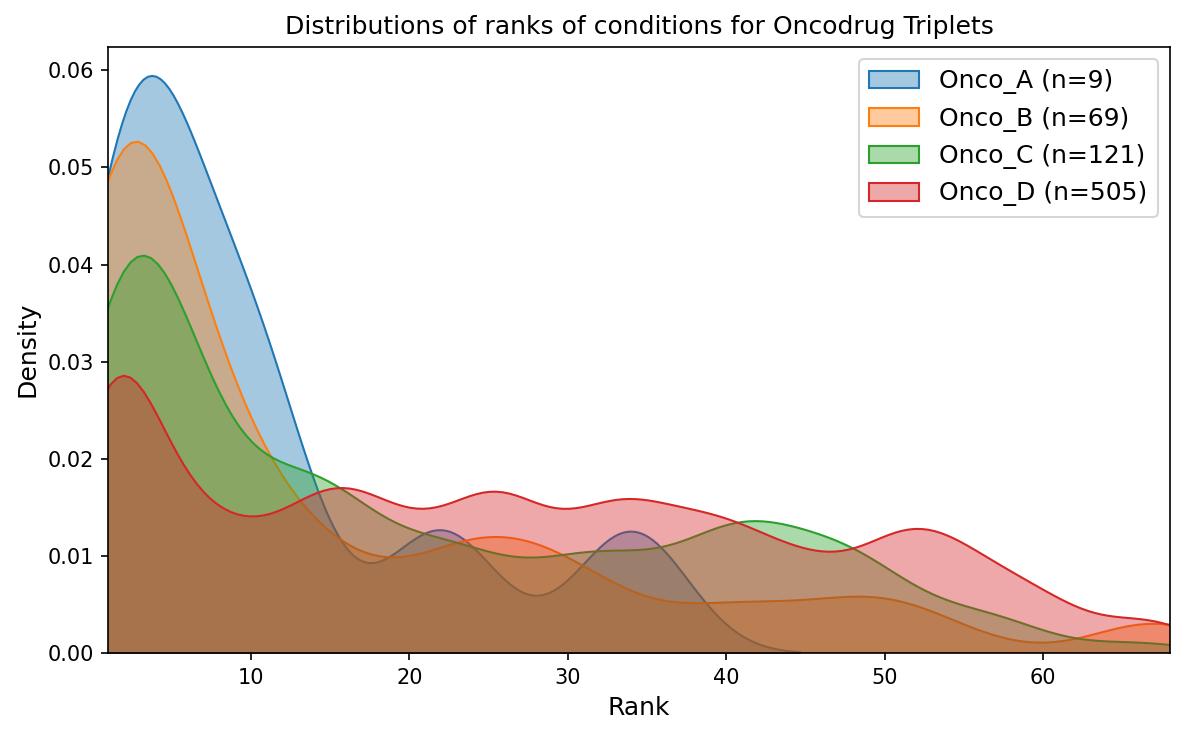

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# List different Level triplets
dfs = [Onco_A, Onco_B, Onco_C, Onco_D]
labels = ['Onco_A', 'Onco_B', 'Onco_C', 'Onco_D']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

sns.reset_defaults()
plt.figure(figsize=(8, 5), dpi=150)

# Plot KDE for each
for df, label, color in zip(dfs, labels, colors):
    sns.kdeplot(
        df['rank'], 
        bw_adjust=0.5, 
        fill=True, 
        alpha=0.4, 
        color=color, 
        label=f"{label} (n={len(df)})"
    )

plt.xlabel("Rank", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distributions of ranks of conditions for Oncodrug Triplets", fontsize=12)

# Set x limits to cover all ranks
plt.xlim(1, max(df['rank'].max() for df in dfs))

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


### Oncodrug triplets analysis - dcomb v.s. drug-condition pair

In [15]:
### Load the finetuned embedding
finetuned_emb = test_model.emb.data
# # it's the same if you load from the source
# emb_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Drug_combinations/06122025/embedding_training_and_finetuning/'
# embedding_save_path = emb_dir+'finetuned_emb_1.npy'
# trained_emb_weights = np.load(embedding_save_path)
# pretrained_embedding = torch.nn.Embedding(N_node, input_emb_size)
# pretrained_embedding.weight.data.copy_(torch.from_numpy(trained_emb_weights))

# combine the Oncodrug triplets
Onco_combined = pd.concat([Onco_A, Onco_B, Onco_C], axis=0)
print(f"There are {Onco_combined.shape[0]} triplets combining Level A,B,C")
Onco_combined = Onco_combined.drop_duplicates().reset_index(drop=True)
print(f"  - {Onco_combined.shape[0]} of them leave after removing duplicates")

There are 199 triplets combining Level A,B,C
  - 196 of them leave after removing duplicates


#### Investigate the rank of dcomb v.s. ranks of drug-condition pairs

In [16]:
# check if drug-cond pairs already exist in AACT or not
existing_pairs = set(zip(drug_cond_df['drug_idx'], drug_cond_df['cond_idx']))
Onco_combined['drug1_cond'] = Onco_combined.apply(
    lambda row: 1 if (row['drug1_idx'], row['cond_idx']) in existing_pairs else 0, axis=1)
Onco_combined['drug2_cond'] = Onco_combined.apply(
    lambda row: 1 if (row['drug2_idx'], row['cond_idx']) in existing_pairs else 0, axis=1)

# find the drug-cond pairs from our training triplets
df1 = combined_df[['drug1_idx', 'cond_idx']].rename(columns={'drug1_idx': 'drug_idx'})
df2 = combined_df[['drug2_idx', 'cond_idx']].rename(columns={'drug2_idx': 'drug_idx'})
combined_df_bypair = pd.concat([df1, df2], ignore_index=True)

# now obtain the rank of drug-cond pairs among drug with all 68 conditions
rank1_list, rank2_list = [], []
num1_list, num2_list = [], []

# iterate over clean triplets from Oncodrug Level B matrix
for i in range(Onco_combined.shape[0]):
    drug1 = Onco_combined['drug1_idx'][i]
    drug2 = Onco_combined['drug2_idx'][i]
    cond = Onco_combined['cond_idx'][i]
    drug_list1 = np.repeat(drug1, len(Onco_cond_idx_list))
    drug_list2 = np.repeat(drug2, len(Onco_cond_idx_list))
    
    ### compute the rank of dot product in the knowledge graph
    drug1_idx_tensor = torch.tensor(drug_list1, dtype=torch.long)
    drug2_idx_tensor = torch.tensor(drug_list2, dtype=torch.long)
    cond_idx_tensor = torch.tensor(Onco_cond_idx_list, dtype=torch.long)
    drug1_emb = finetuned_emb[drug1_idx_tensor]
    drug2_emb = finetuned_emb[drug2_idx_tensor]
    cond_emb = finetuned_emb[cond_idx_tensor]
    # for drug1
    dot_products = (drug1_emb * cond_emb).sum(dim=1)
    cond_idx = Onco_cond_idx_list.index(cond)
    ranks = rankdata(-dot_products, method='min')  # descending
    this_rank = ranks[cond_idx]
    rank1_list.append(this_rank)
    # for drug2
    dot_products = (drug2_emb * cond_emb).sum(dim=1)
    cond_idx = Onco_cond_idx_list.index(cond)
    ranks = rankdata(-dot_products, method='min')  # descending
    this_rank = ranks[cond_idx]
    rank2_list.append(this_rank)
    
    ### Compute the rank of frequency
    # for drug1
    cond_list = combined_df_bypair[combined_df_bypair['drug_idx']==drug1]['cond_idx']
    cond_freq_list = cond_list.value_counts()
    if cond in cond_freq_list:
        drug_freq = cond_freq_list[cond]
        # find the condition in Oncodrug
        filtered_freq_list = cond_freq_list[cond_freq_list.index.isin(Onco_cond_idx_list)]
        # Count how many have frequency >= drug_freq (including itself)
        num_geq = int((filtered_freq_list >= drug_freq).sum())
        num1_list.append(num_geq)
    else:
        num1_list.append(np.nan)
    # for drug2
    cond_list = combined_df_bypair[combined_df_bypair['drug_idx']==drug2]['cond_idx']
    cond_freq_list = cond_list.value_counts()
    if cond in cond_freq_list:
        drug_freq = cond_freq_list[cond]
        filtered_freq_list = cond_freq_list[cond_freq_list.index.isin(Onco_cond_idx_list)]
        num_geq = int((filtered_freq_list >= drug_freq).sum())
        num2_list.append(num_geq)
    else:
        num2_list.append(np.nan)
    
# add to the dataframe
Onco_combined["drug1_cond_rank"] = rank1_list
Onco_combined["drug2_cond_rank"] = rank2_list
Onco_combined["drug1_num_gep"] = num1_list
Onco_combined["drug2_num_gep"] = num2_list
Onco_combined


,drug1_id,drug2_id,condition_id,drug1_idx,drug2_idx,cond_idx,score,rank,drug1_cond,drug2_cond,drug1_cond_rank,drug2_cond_rank,drug1_num_gep,drug2_num_gep
0,DB01101,DB01269,D015179,45,696,1888,3.984746e-06,2,1,1,4,7,3.0,1.0
1,DB01234,DB01254,D019337,48,572,2687,2.997183e-09,22,1,1,48,16,NaN,NaN
2,DB01254,DB04868,D015464,572,847,2114,2.790470e-04,3,1,1,3,4,3.0,3.0
3,DB00755,DB01169,D015470,181,344,1903,2.102471e-25,10,1,1,4,6,NaN,NaN
4,DB01269,DB15569,D015179,696,1171,1888,0.000000e+00,34,1,1,7,4,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,DB01041,DB01169,D001943,74,344,1838,2.170883e-25,3,1,1,24,30,NaN,NaN
192,DB00317,DB01169,D010049,643,344,3261,1.681086e-22,39,0,0,60,68,16.0,NaN
193,DB00530,DB01169,D010049,479,344,3261,4.004191e-13,28,0,0,67,68,21.0,NaN
194,DB00072,DB00619,D046152,379,69,2377,7.279396e-12,23,0,1,30,5,NaN,6.0


#### Rank difference between dcomb and drug-cond pair from AACT

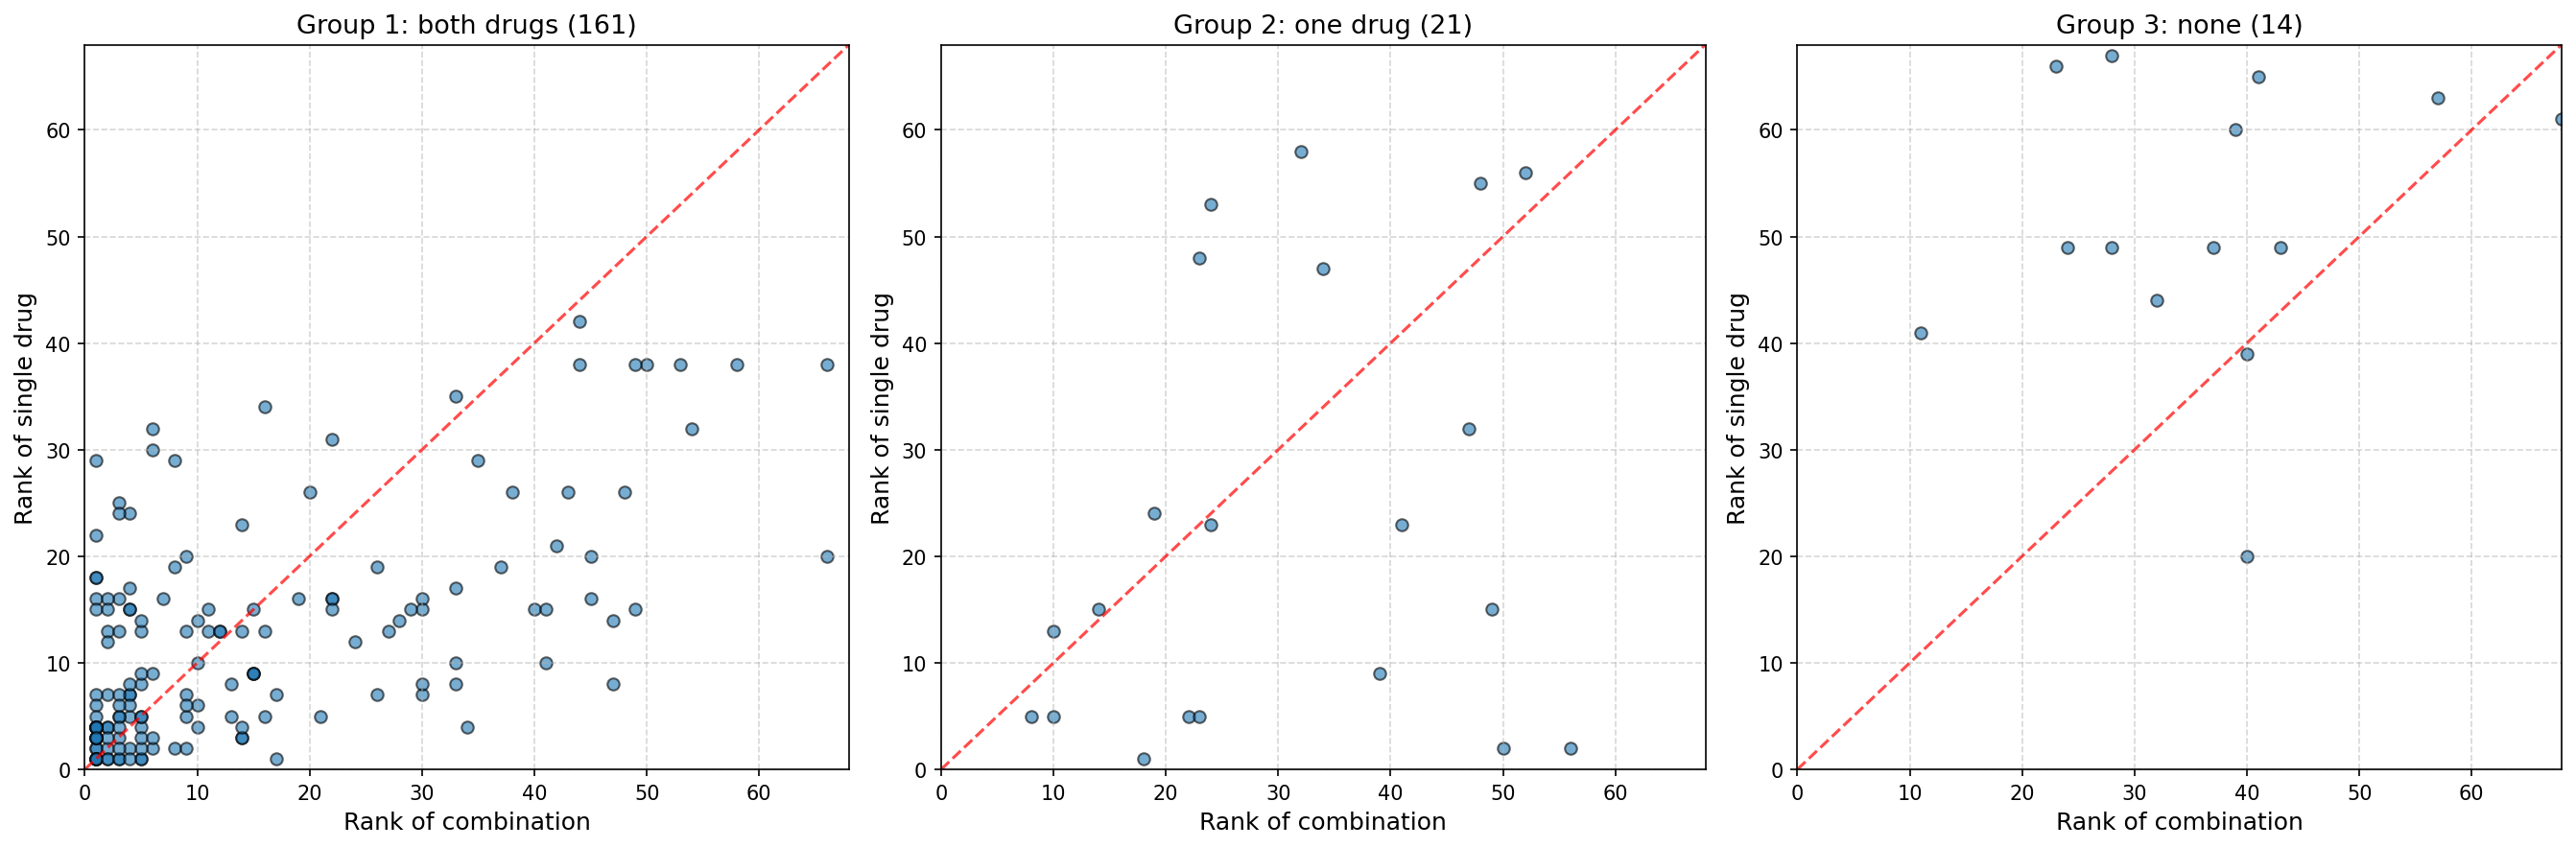

In [17]:
# - group 1: for both drugs, drug-cond pair is in AACT
OC_group1 = Onco_combined[(Onco_combined['drug1_cond'] == 1) & (Onco_combined['drug2_cond'] == 1)]
# - group 2: for one and only one drug, drug-cond pair is in AACT
OC_group2 = Onco_combined[
    ((Onco_combined['drug1_cond'] == 1) & (Onco_combined['drug2_cond'] == 0)) |
    ((Onco_combined['drug1_cond'] == 0) & (Onco_combined['drug2_cond'] == 1))]
# - group 3: no drug-cond pair is in AACT
OC_group3 = Onco_combined[(Onco_combined['drug1_cond'] == 0) & (Onco_combined['drug2_cond'] == 0)]

# find the rank for drug-cond pair
OC_group1['cond_rank'] = OC_group1[['drug1_cond_rank', 'drug2_cond_rank']].min(axis=1)
OC_group2['cond_rank'] = np.where(
    OC_group2['drug1_cond'] == 1,
    OC_group2['drug1_cond_rank'],  # if drug1_cond is 1, use its rank
    OC_group2['drug2_cond_rank'])  # else, use drug2_cond_rank
OC_group3['cond_rank'] = OC_group3[['drug1_cond_rank', 'drug2_cond_rank']].min(axis=1)

# Plotting all three groups in one row
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=150)
max_rank = len(Onco_cond_list)
groups = [OC_group1, OC_group2, OC_group3]
titles = [
    f'Group 1: both drugs ({OC_group1.shape[0]})',
    f'Group 2: one drug ({OC_group2.shape[0]})',
    f'Group 3: none ({OC_group3.shape[0]})'
]

for ax, group, title in zip(axes, groups, titles):
    ax.scatter(group['rank'], group['cond_rank'], alpha=0.6, edgecolor='k')
    
    # Set axis labels and title
    ax.set_xlabel('Rank of combination', fontsize=12)
    ax.set_ylabel('Rank of single drug', fontsize=12)
    ax.set_title(title, fontsize=13)
    
    # Fix x and y limits
    ax.set_xlim(0, max_rank)
    ax.set_ylim(0, max_rank)
    
    # Add diagonal line x=y
    ax.plot([0, max_rank], [0, max_rank], linestyle='--', color='red', alpha=0.7)
    
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

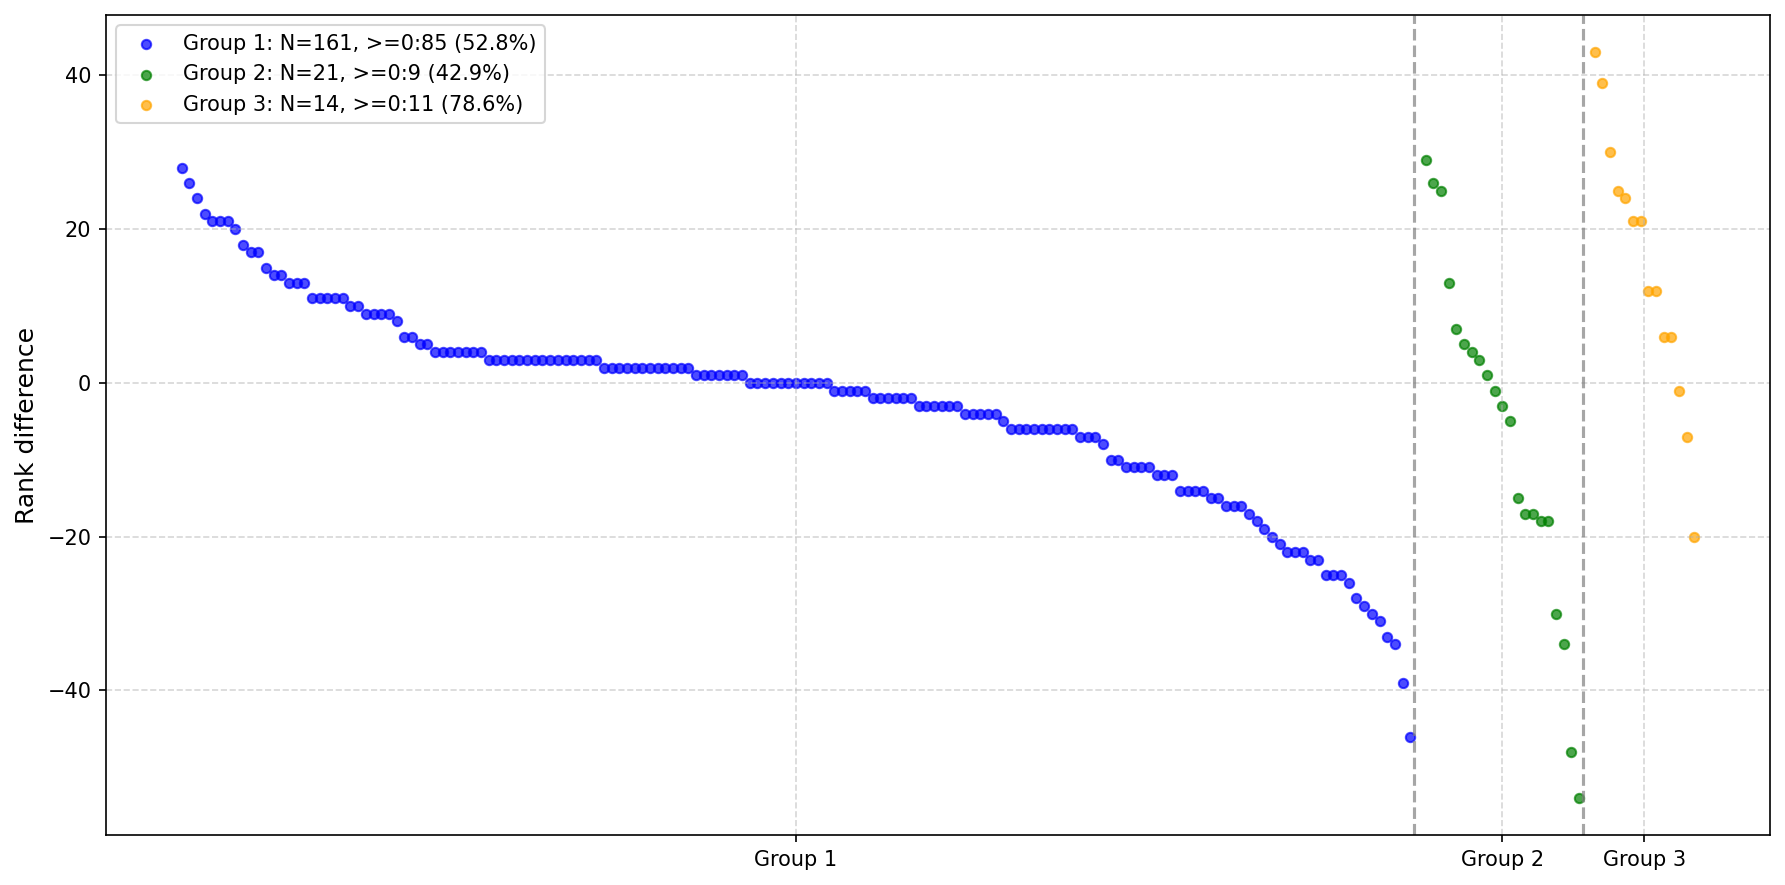

In [18]:
# Compute y-axis value
for group in [OC_group1, OC_group2, OC_group3]:
    group['y_diff'] = group['cond_rank'] - group['rank']

# Sort each group descending by y_diff
OC_group1_sorted = OC_group1.sort_values('y_diff', ascending=False).reset_index(drop=True)
OC_group2_sorted = OC_group2.sort_values('y_diff', ascending=False).reset_index(drop=True)
OC_group3_sorted = OC_group3.sort_values('y_diff', ascending=False).reset_index(drop=True)

# Assign x positions for each dot
x_group1 = np.arange(len(OC_group1_sorted))
x_group2 = np.arange(len(OC_group2_sorted)) + len(OC_group1_sorted) + 1
x_group3 = np.arange(len(OC_group3_sorted)) + len(OC_group1_sorted) + len(OC_group2_sorted) + 2

plt.figure(figsize=(12,6), dpi=150)

# Function to generate legend text
def legend_text(group_sorted, name):
    total = len(group_sorted)
    geq0 = (group_sorted['y_diff'] >= 0).sum()
    pct = geq0 / total * 100 if total > 0 else 0
    return f"{name}: N={total}, >=0:{geq0} ({pct:.1f}%)"

# Plot each group with smaller dots
plt.scatter(x_group1, OC_group1_sorted['y_diff'], color='blue', alpha=0.7, s=20, label=legend_text(OC_group1_sorted, 'Group 1'))
plt.scatter(x_group2, OC_group2_sorted['y_diff'], color='green', alpha=0.7, s=20, label=legend_text(OC_group2_sorted, 'Group 2'))
plt.scatter(x_group3, OC_group3_sorted['y_diff'], color='orange', alpha=0.7, s=20, label=legend_text(OC_group3_sorted, 'Group 3'))

# X-axis ticks at center of each group
group_centers = [
    np.mean(x_group1) if len(x_group1) > 0 else 0,
    np.mean(x_group2) if len(x_group2) > 0 else 0,
    np.mean(x_group3) if len(x_group3) > 0 else 0
]
plt.xticks(group_centers, ['Group 1', 'Group 2', 'Group 3'])

# Add vertical dashed lines to separate groups
if len(x_group1) > 0:
    plt.axvline(x=max(x_group1)+0.5, color='gray', linestyle='--', alpha=0.7)
if len(x_group2) > 0:
    plt.axvline(x=max(x_group2)+0.5, color='gray', linestyle='--', alpha=0.7)

# Labels and grid
plt.ylabel('Rank difference', fontsize=12)
# plt.xlabel('Groups', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Legend
plt.legend()
plt.tight_layout()
plt.show()

#### Rank difference between dcomb and drug-cond pair from training triplets

In [19]:
### we pick those triplets where at least one drug has been applied to the condition from our training triplets
# Create new column with the smaller number, NA if both are NA
Onco_combined['min_num_gep'] = Onco_combined[['drug1_num_gep', 'drug2_num_gep']].min(axis=1, skipna=True)
both_na = Onco_combined[['drug1_num_gep', 'drug2_num_gep']].isna().all(axis=1)
Onco_combined.loc[both_na, 'min_num_gep'] = np.nan
Onco_combined_filtered = Onco_combined[Onco_combined['min_num_gep'].notna()]
Onco_combined_filtered

,drug1_id,drug2_id,condition_id,drug1_idx,drug2_idx,cond_idx,score,rank,drug1_cond,drug2_cond,drug1_cond_rank,drug2_cond_rank,drug1_num_gep,drug2_num_gep,min_num_gep
0,DB01101,DB01269,D015179,45,696,1888,3.984746e-06,2,1,1,4,7,3.0,1.0,1.0
2,DB01254,DB04868,D015464,572,847,2114,2.790470e-04,3,1,1,3,4,3.0,3.0,3.0
4,DB01269,DB15569,D015179,696,1171,1888,0.000000e+00,34,1,1,7,4,1.0,NaN,1.0
6,DB09074,DB11760,D001943,162,359,1838,1.846344e-06,1,1,1,4,3,1.0,1.0,1.0
7,DB00072,DB00515,D013274,379,9,1914,8.390480e-04,6,1,1,39,32,5.0,8.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,DB00398,DB01169,D001943,352,344,1838,2.769795e-09,15,1,1,9,30,12.0,NaN,12.0
192,DB00317,DB01169,D010049,643,344,3261,1.681086e-22,39,0,0,60,68,16.0,NaN,16.0
193,DB00530,DB01169,D010049,479,344,3261,4.004191e-13,28,0,0,67,68,21.0,NaN,21.0
194,DB00072,DB00619,D046152,379,69,2377,7.279396e-12,23,0,1,30,5,NaN,6.0,6.0


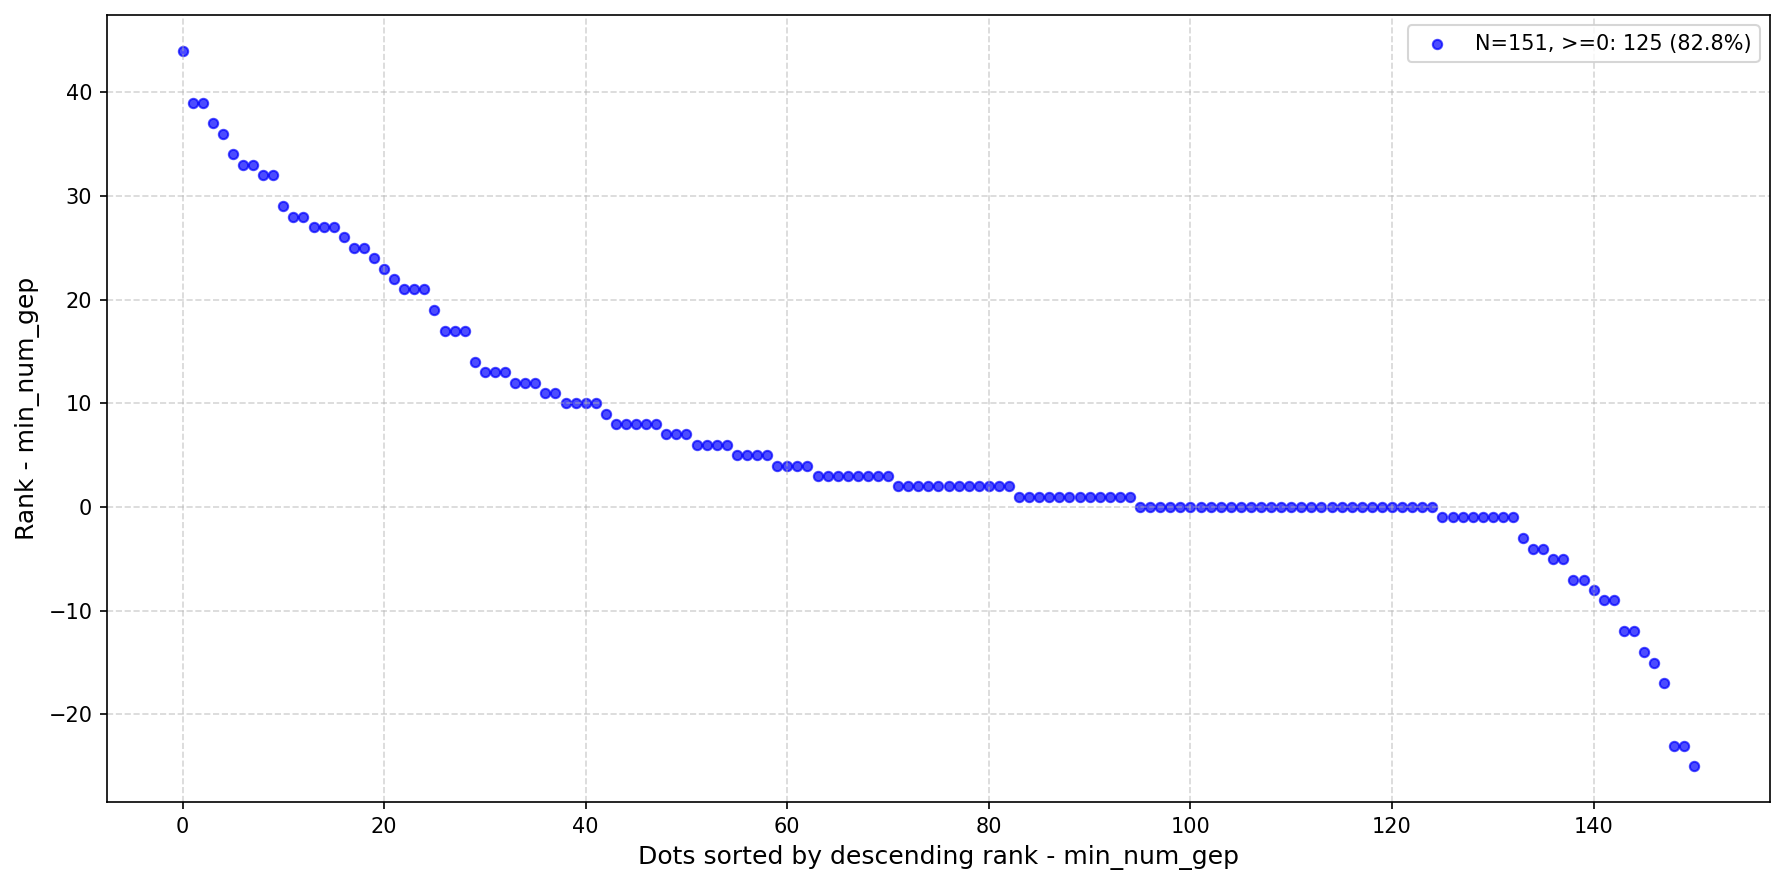

In [20]:
# Copy dataframe
df = Onco_combined_filtered.copy()

# Compute y-axis: rank - min_num_gep
df['y_diff'] = df['rank'] - df['min_num_gep']

# Sort descending by y_diff
df_sorted = df.sort_values('y_diff', ascending=False).reset_index(drop=True)

# Assign x positions (each dot gets its own x tick)
x_pos = np.arange(len(df_sorted))

# Calculate percentage of dots >= 0
num_ge0 = (df_sorted['y_diff'] >= 0).sum()
total = len(df_sorted)
pct_ge0 = num_ge0 / total * 100 if total > 0 else 0

plt.figure(figsize=(12,6), dpi=150)

# Plot the dots
plt.scatter(x_pos, df_sorted['y_diff'], color='blue', alpha=0.7, s=20, 
            label=f'N={total}, >=0: {num_ge0} ({pct_ge0:.1f}%)')

# Labels and grid
plt.xlabel('Dots sorted by descending rank - min_num_gep', fontsize=12)
plt.ylabel('Rank - min_num_gep', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Add legend
plt.legend()
plt.tight_layout()
plt.show()

#### Compare drug-cond pairs from AACT with our prediction on Oncodrug triplets

In [21]:
Onco_combined = Onco_combined
dp_list, dp_label = [], []

# compute the prediction score for each Oncodrug triplets
for i in range(Onco_combined.shape[0]):
    drug1 = Onco_combined['drug1_idx'][i]
    drug2 = Onco_combined['drug2_idx'][i]
    cond = Onco_combined['cond_idx'][i]
    n_cond = len(Onco_cond_idx_list)
    drug_list1 = np.repeat(drug1, len(Onco_cond_idx_list))
    drug_list2 = np.repeat(drug2, len(Onco_cond_idx_list))
    # find the condition index
    cond_idx = Onco_cond_idx_list.index(cond)
    
    ### compute the dot product of each drug-cond pair
    drug1_idx_tensor = torch.tensor(drug_list1, dtype=torch.long)
    drug2_idx_tensor = torch.tensor(drug_list2, dtype=torch.long)
    cond_idx_tensor = torch.tensor(Onco_cond_idx_list, dtype=torch.long)
    drug1_emb = finetuned_emb[drug1_idx_tensor]
    drug2_emb = finetuned_emb[drug2_idx_tensor]
    cond_emb = finetuned_emb[cond_idx_tensor]
    # compute dot product
    dot_products_list1 = (drug1_emb * cond_emb).sum(dim=1)
    dot_products_list2 = (drug2_emb * cond_emb).sum(dim=1)
    dot_products_label1 = np.zeros(n_cond)
    dot_products_label1[cond_idx] = 1
    dot_products_label2 = np.zeros(n_cond)
    dot_products_label2[cond_idx] = 1  
    # append the results
    dp_list.append(dot_products_list1)
    dp_list.append(dot_products_list2)
    dp_label.append(dot_products_label1)
    dp_label.append(dot_products_label2)

dp_list = np.array(dp_list).flatten()
dp_label = np.array(dp_label).flatten()
roc_auc = roc_auc_score(dp_label, dp_list)
pr_auc = average_precision_score(dp_label, dp_list)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

ROC-AUC: 0.6649
PR-AUC: 0.0258


In [22]:
Onco_combined = Onco_combined
pred_list, pred_label = [], []

# compute the prediction score for each Oncodrug triplets
for i in range(Onco_combined.shape[0]):
    drug1 = Onco_combined['drug1_idx'][i]
    drug2 = Onco_combined['drug2_idx'][i]
    cond = Onco_combined['cond_idx'][i]
    n_cond = len(Onco_cond_idx_list)
    drug_list1 = np.repeat(drug1, len(Onco_cond_idx_list))
    drug_list2 = np.repeat(drug2, len(Onco_cond_idx_list))
    # find the condition index
    cond_idx = Onco_cond_idx_list.index(cond)
    
    ### compute the prediction of triplets
    drug1_idx_tensor = torch.tensor(drug_list1, dtype=torch.long)
    drug2_idx_tensor = torch.tensor(drug_list2, dtype=torch.long)
    cond_idx_tensor = torch.tensor(Onco_cond_idx_list, dtype=torch.long)
    pred = test_model.forward(drug_list1, drug_list2, Onco_cond_idx_list)
    prediction_list = np.atleast_1d(pred.detach().cpu().numpy()).tolist()
    prediction_label = np.zeros(n_cond)
    prediction_label[cond_idx] = 1

    # append the results
    pred_list.append(prediction_list)
    pred_label.append(prediction_label)

pred_list = np.array(pred_list).flatten()
pred_label = np.array(pred_label).flatten()
roc_auc = roc_auc_score(pred_label, pred_list)
pr_auc = average_precision_score(pred_label, pred_list)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

ROC-AUC: 0.6378
PR-AUC: 0.0492


### Oncodrug triplets analysis - rank of second drug and dcomb

#### Rank of second drug

In [63]:
# combine the Oncodrug triplets
# Onco_combined = pd.concat([Onco_A, Onco_B, Onco_C], axis=0)
Onco_combined = pd.concat([Onco_A], axis=0)
print(f"There are {Onco_combined.shape[0]} triplets combining Level A,B,C")
Onco_combined = Onco_combined.drop_duplicates().reset_index(drop=True)
print(f"  - {Onco_combined.shape[0]} of them leave after removing duplicates")
# predefine new columns
Onco_combined_ranking = Onco_combined.copy()
Onco_combined_ranking['drug1_rank_in_[drug2_condition]'] = -1
Onco_combined_ranking['drug2_rank_in_[drug1_condition]'] = -1

# find all the existing triplets
all_triplets = [
    sorted([drug1, drug2]) + [cond]
    for drug1, drug2, cond in zip(combined_df['drug1_idx'], combined_df['drug2_idx'], combined_df['cond_idx'])
]
all_triplets = np.array(all_triplets)

# all the unique drug
all_unique_drug_idx_set = set(drug_cond_df['drug_idx'].tolist())

# Predefine the output arrays with integer data type
drug2_rank_results = np.zeros(Onco_combined_ranking.shape[0], dtype=int)
drug1_rank_results = np.zeros(Onco_combined_ranking.shape[0], dtype=int)


There are 23 triplets combining Level A,B,C
  - 23 of them leave after removing duplicates


In [54]:
batch = 100  # Number of iterations per epoch
start_time = time.time()

print("-----Start ranking computation-----")
for batch_start in range(0, Onco_combined_ranking.shape[0], batch):
    # Initialize batch data
    batch_triplets_drug2 = []
    batch_triplets_drug1 = []
    batch_num_triplets_drug2 = []
    batch_num_triplets_drug1 = []
    batch_indices = range(batch_start, min(batch_start + batch, Onco_combined_ranking.shape[0]))

    for i in batch_indices:
        # Extract drug and condition indices for current row
        drug1_idx = Onco_combined_ranking['drug1_idx'][i]
        drug2_idx = Onco_combined_ranking['drug2_idx'][i]
        cond_idx = Onco_combined_ranking['cond_idx'][i]

        # **Compute drug2_rank_in_[drug1_condition]**
        # Filter triplets by condition and anchor drug (drug1)
        condition_mask = (all_triplets[:, 2] == cond_idx)
        drug_mask = (all_triplets[:, 0] == drug1_idx) | (all_triplets[:, 1] == drug1_idx)
        existing_triplets_by_cond_by_drug2 = all_triplets[condition_mask & drug_mask]

        # Extract drug partners for drug1
        drug_list1, drug_list2 = existing_triplets_by_cond_by_drug2[:, 0], existing_triplets_by_cond_by_drug2[:, 1]
        existing_partner_set = set(drug_list1).union(drug_list2) - {drug1_idx}

        # Determine candidate drug list for drug2 ranking
        drug_to_filter_out = {drug2_idx, drug1_idx}.union(existing_partner_set)
        other_candidate_drug_list = list(all_unique_drug_idx_set - drug_to_filter_out)
        all_candidate_drug_list = [drug2_idx] + other_candidate_drug_list

        # Collect triplets for the batch
        possible_triplets_drug2 = [[drug1_idx, drug, cond_idx] for drug in all_candidate_drug_list]
        batch_triplets_drug2.extend(possible_triplets_drug2)
        batch_num_triplets_drug2.append(len(possible_triplets_drug2))

        # **Compute drug1_rank_in_[drug2_condition]**
        # Filter triplets by condition and anchor drug (drug2)
        drug_mask = (all_triplets[:, 0] == drug2_idx) | (all_triplets[:, 1] == drug2_idx)
        existing_triplets_by_cond_by_drug1 = all_triplets[condition_mask & drug_mask]

        # Extract drug partners for drug2
        drug_list1, drug_list2 = existing_triplets_by_cond_by_drug1[:, 0], existing_triplets_by_cond_by_drug1[:, 1]
        existing_partner_set = set(drug_list1).union(drug_list2) - {drug2_idx}

        # Determine candidate drug list for drug1 ranking
        drug_to_filter_out = {drug1_idx, drug2_idx}.union(existing_partner_set)
        other_candidate_drug_list = list(all_unique_drug_idx_set - drug_to_filter_out)
        all_candidate_drug_list = [drug1_idx] + other_candidate_drug_list

        # Collect triplets for the batch
        possible_triplets_drug1 = [[drug2_idx, drug, cond_idx] for drug in all_candidate_drug_list]
        batch_triplets_drug1.extend(possible_triplets_drug1)
        batch_num_triplets_drug1.append(len(possible_triplets_drug1))

    # Convert batch triplets to NumPy arrays for prediction
    batch_triplets_drug2 = np.array(batch_triplets_drug2)
    drug_list1_drug2, drug_list2_drug2, cond_list_drug2 = batch_triplets_drug2.T

    batch_triplets_drug1 = np.array(batch_triplets_drug1)
    drug_list1_drug1, drug_list2_drug1, cond_list_drug1 = batch_triplets_drug1.T

    # Run the model on the entire batch for both rankings
    batch_predictions_drug2 = test_model.forward(drug_list1_drug2, drug_list2_drug2, cond_list_drug2)
    batch_predictions_drug1 = test_model.forward(drug_list1_drug1, drug_list2_drug1, cond_list_drug1)

    # Split predictions and calculate ranks for each iteration
    start_idx_drug2 = 0
    start_idx_drug1 = 0

    for idx, i in enumerate(batch_indices):
        # **Rank for drug2**
        num_triplets_drug2 = batch_num_triplets_drug2[idx]
        predictions_drug2 = batch_predictions_drug2[start_idx_drug2:start_idx_drug2 + num_triplets_drug2]
        start_idx_drug2 += num_triplets_drug2

        # Detach and convert to NumPy
        predictions_drug2 = predictions_drug2.detach().cpu().numpy()
        ranks_drug2 = rankdata(-predictions_drug2, method='ordinal')
        drug2_rank_results[i] = int(ranks_drug2[0])

        # **Rank for drug1**
        num_triplets_drug1 = batch_num_triplets_drug1[idx]
        predictions_drug1 = batch_predictions_drug1[start_idx_drug1:start_idx_drug1 + num_triplets_drug1]
        start_idx_drug1 += num_triplets_drug1

        # Detach and convert to NumPy
        predictions_drug1 = predictions_drug1.detach().cpu().numpy()
        ranks_drug1 = rankdata(-predictions_drug1, method='ordinal')
        drug1_rank_results[i] = int(ranks_drug1[0])

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"time for finishing executing {i+1} triplets: {int(execution_time)} seconds")

# Store results in the dataframe
Onco_combined_ranking['drug2_rank_in_[drug1_condition]'] = drug2_rank_results
Onco_combined_ranking['drug1_rank_in_[drug2_condition]'] = drug1_rank_results

print("-----Ranking computation completed-----")


-----Start ranking computation-----
time for finishing executing 100 triplets: 13 seconds
time for finishing executing 200 triplets: 27 seconds
time for finishing executing 300 triplets: 40 seconds
time for finishing executing 400 triplets: 54 seconds
time for finishing executing 500 triplets: 68 seconds
time for finishing executing 524 triplets: 72 seconds
-----Ranking computation completed-----


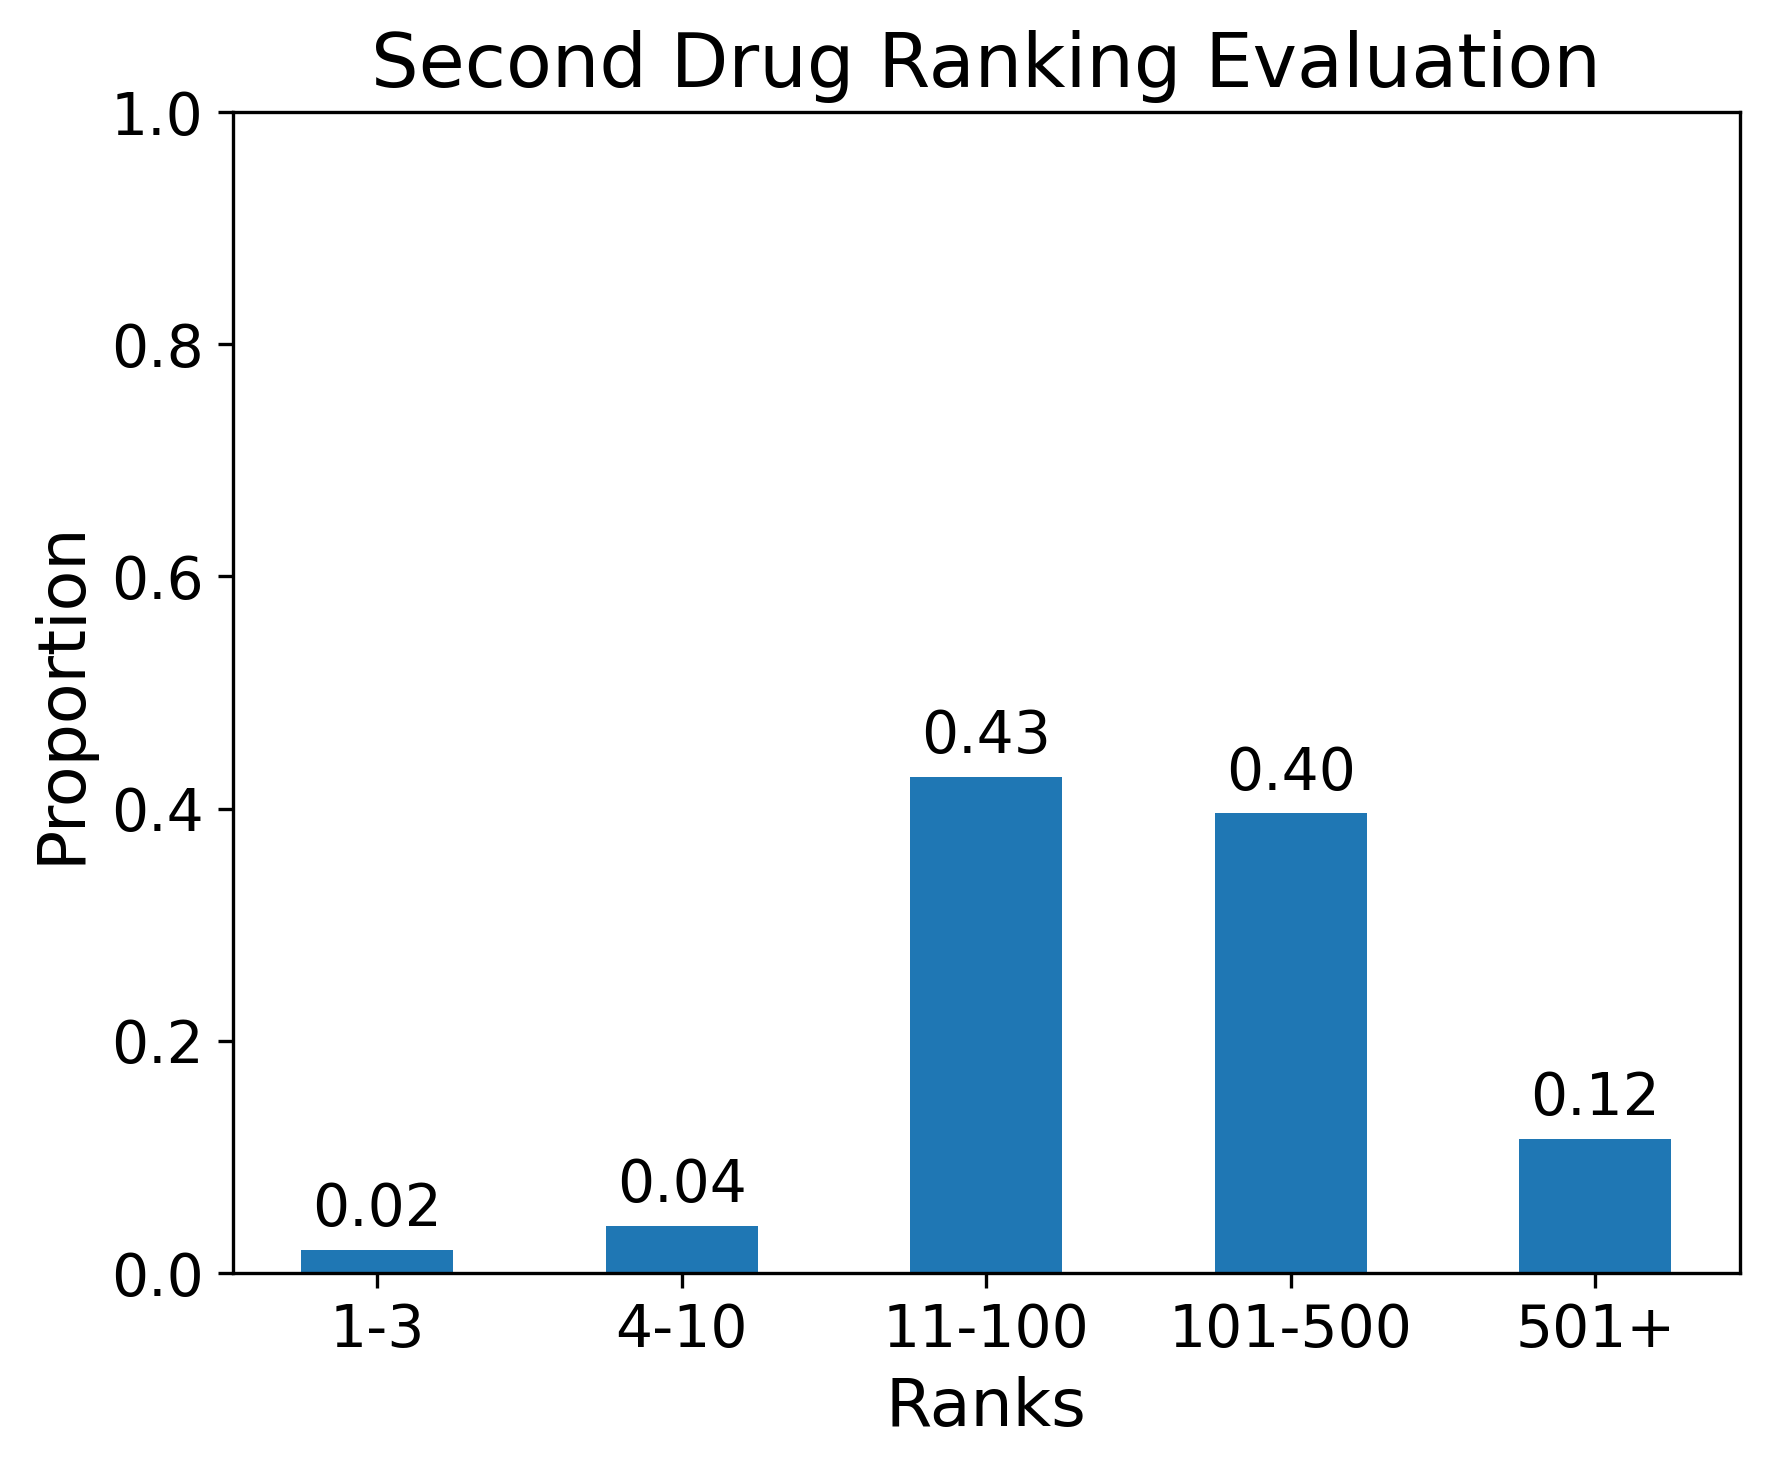

In [55]:
# visualization
rank_list1 = Onco_combined_ranking['drug1_rank_in_[drug2_condition]'].tolist()
rank_list2 = Onco_combined_ranking['drug2_rank_in_[drug1_condition]'].tolist()
rank_list = rank_list1 + rank_list2

bins = [1, 4, 11, 101, 501, max(rank_list) + 1]
freq = [0] * (len(bins) - 1)
for num in rank_list:
    for i in range(len(bins) - 1):
        if bins[i] <= num < bins[i + 1]:
            freq[i] += 1
            break
total = sum(freq)
proportions = [f / total for f in freq]

fig, ax = plt.subplots(figsize=(6, 5), dpi=300)
labels = ['1-3', '4-10', '11-100', '101-500', '501+']
ax.bar(labels, proportions, width=0.5)
ax.set_title("Second Drug Ranking Evaluation", fontsize=18)
ax.set_xlabel("Ranks", fontsize=16)
ax.set_ylabel("Proportion", fontsize=16)
ax.set_ylim(0, 1)

# annotate bars
for j, p in enumerate(proportions):
    ax.text(j, p + 0.01, f'{p:.2f}', ha='center', va='bottom', fontsize=14)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.show()


#### Ranks among all alternative triplets

In [71]:
# combine the Oncodrug triplets
# Onco_combined = pd.concat([Onco_A, Onco_B, Onco_C], axis=0)
Onco_combined = pd.concat([Onco_A], axis=0)
print(f"There are {Onco_combined.shape[0]} triplets combining Level A,B,C")
Onco_combined = Onco_combined.drop_duplicates().reset_index(drop=True)
print(f"  - {Onco_combined.shape[0]} of them leave after removing duplicates")

# find all the existing triplets
all_triplets = [
    sorted([drug1, drug2]) + [cond]
    for drug1, drug2, cond in zip(combined_df['drug1_idx'], combined_df['drug2_idx'], combined_df['cond_idx'])
]

# all the unique drug
all_unique_drug_idx_set = set(drug_cond_df['drug_idx'].tolist())

# find all the existing triplets
Onco_triplets = [
    sorted([drug1, drug2]) + [cond]
    for drug1, drug2, cond in zip(Onco_combined['drug1_idx'], Onco_combined['drug2_idx'], Onco_combined['cond_idx'])
]

There are 23 triplets combining Level A,B,C
  - 23 of them leave after removing duplicates


In [ ]:
def advanced_calculate_rank_percentile_list(A, B):
    B_sorted = np.sort(B)
    c1, c2 = 0, 0
    rank_percentiles = []
    for element in A:
        # Find the actual rank of the element in B
        position = np.searchsorted(B_sorted, element, side='left')
        rank_position = len(B) - position
        # Find the percentile of the element in B
        percentile = position / len(B)
        rank_percentile = 1 - percentile
        # conditions
        if rank_position <= 9:
            c1 = c1+1
        elif rank_position <=49:
            c2 = c2+1
        else:
            rank_percentiles.append(rank_percentile)

    return c1, c2, rank_percentiles

# find all the drug idx and condition idx
all_unique_drug_idx_list = sorted(set(drug_cond_df['drug_idx'].tolist()))
all_unique_cond_idx_list = sorted(set(drug_cond_df['cond_idx'].tolist()))

rank_percentile_list_oncodrug_triplets = []
top10_rank_oncodrug_triplets, top50_rank_oncodrug_triplets = 0, 0

# all the combinations of any two drugs
drug_combinations = [list(pair) for pair in itertools.combinations(all_unique_drug_idx_list, 2)]

covered_cond_idx = list(set(np.array(all_triplets).T[2]))
print(f"There are {len(covered_cond_idx)} conditions in existing triplets")

for cond_idx in covered_cond_idx:
    sub_existing_triplets = [t for t in all_triplets if t[2]==cond_idx]
    sub_oncodrug_triplets = [t for t in Onco_triplets if t[2]==cond_idx]
    # generate all negative triplets
    tmp_triplet1 = [pair + [cond_idx] for pair in drug_combinations]
    # filter out existing triplets
    tmp_triplet = [x for x in tmp_triplet1 if x not in sub_existing_triplets]
    
    # Adjust batch size based on memory
    negative_samples_pred_list = []
    bs = int(len(tmp_triplet)/5)+1  
    for i in range(0, len(tmp_triplet), bs):
        batch = tmp_triplet[i:i+bs]
        drug_list1, drug_list2, cond_list = np.array(batch).T
        pred = test_model.forward(drug_list1, drug_list2, cond_list)
        negative_samples_pred_list.extend(pred.detach().cpu().numpy())
    
    # print(len(negative_samples_pred_list))
    # compute the prediction of oncodrug triplets
    if len(sub_oncodrug_triplets)>0:
        drug_list1, drug_list2, cond_list = np.array(sub_oncodrug_triplets).T
        pred = test_model.forward(drug_list1, drug_list2, cond_list)
        pred_list = np.atleast_1d(pred.detach().cpu().numpy())
        c1, c2, rank_percentiles = advanced_calculate_rank_percentile_list(pred_list, negative_samples_pred_list)
        rank_percentile_list_oncodrug_triplets = rank_percentile_list_oncodrug_triplets + rank_percentiles
        top10_rank_oncodrug_triplets = top10_rank_oncodrug_triplets + c1
        top50_rank_oncodrug_triplets = top50_rank_oncodrug_triplets + c2


There are 1811 conditions in existing triplets


In [ ]:
# Define bins
bins = [0, 0.0001, 0.001, 0.01, 0.1, 1]

fig, axs = plt.subplots(1, 1, figsize=(6, 5), sharey=True, dpi=300)

# plot 
hist, bin_edges = np.histogram(rank_percentile_list_oncodrug_triplets, bins=bins)
hist = np.array([top10_rank_oncodrug_triplets] + [top50_rank_oncodrug_triplets] + list(hist))
bars0 = axs.bar(range(len(hist)), hist/hist.sum(), width=0.8, edgecolor='black', align='center')
axs.set_xticks(range(len(hist)))
axs.set_xticklabels(['1~10', '11~50', '51~0.01%(188)', '0.01%-0.1%', '0.1%-1%', '1%-10%', '>10%'], fontsize=13, rotation=45)
axs.set_ylabel('Proportion', fontsize=16)
axs.set_title(f'Level A', fontsize=16)
axs.set_ylim(0, 1.0)

# Modify font size for y-axis ticks (the tick labels on the y-axis)
for label in axs.get_yticklabels():
    label.set_fontsize(14)  # Change the fontsize here
# Add percentage on top of each bar in the first plot
for bar in bars0:
    height = bar.get_height()
    height_pos = height + 0.004
    axs.text(bar.get_x() + bar.get_width() / 2, height_pos, f'{height*100:.1f}%', ha='center', va='bottom', fontsize=13)

# Adjust layout
plt.tight_layout()


### Oncodrug triplets analysis - Part 3

#### rank of dcomb v.s. dcomb (rep second drug) within same condition

In [17]:
def rank_of_dcomb_by_cond(combined_df, OC_Level="A", Option=1):
    """ 
    Note:
      - We only include Oncodrug triplets where both drugs have been applied on the condition in AACT
    Input:
      - combined_df: all the known CDCDB triplets we used when trained the model
      - OC_Level: which level of Oncodrug triplets you want to investigate
      - Option: different options for picking alternative negative drug combination
        - 1: all alternative negative drug combination
        - 2: alternative negative drug combination from fixing one drug
    Output:
      - count_rank1: how many rank 1
      - count_gt_ref: how many not rank 1 but > 95%
      - count_rest: rest
    """

    # read different level OC triplets
    if OC_Level=="A":
        Onco_df = Onco_A.copy()
    if OC_Level=="B":
        Onco_df = Onco_B.copy()
    if OC_Level=="C":
        Onco_df = Onco_C.copy()
    if OC_Level=="D":
        Onco_df = Onco_D.copy()
    Onco_df = Onco_df.drop_duplicates().reset_index(drop=True)

    # check if drug-cond pairs already exist in AACT or not
    existing_pairs = set(zip(drug_cond_df['drug_idx'], drug_cond_df['cond_idx']))
    Onco_df['drug1_cond'] = Onco_df.apply(
        lambda row: 1 if (row['drug1_idx'], row['cond_idx']) in existing_pairs else 0, axis=1)
    Onco_df['drug2_cond'] = Onco_df.apply(
        lambda row: 1 if (row['drug2_idx'], row['cond_idx']) in existing_pairs else 0, axis=1)
    # - group 1: for both drugs, drug-cond pair is in CDCDB
    OC_group1 = Onco_df[(Onco_df['drug1_cond'] == 1) & (Onco_df['drug2_cond'] == 1)].reset_index(drop=True)
    OC_group1 = OC_group1.drop(['rank', 'drug1_cond', 'drug2_cond'], axis=1)
    
    # find all the existing triplets
    all_triplets = [
        sorted([drug1, drug2]) + [cond]
        for drug1, drug2, cond in zip(combined_df['drug1_idx'], combined_df['drug2_idx'], combined_df['cond_idx'])
    ]
    
    # record the following results
    OC_group1['dcomb_score'] = -1
    OC_group1['ref_score_ci_95'] = -1
    OC_group1['dcomb_rank'] = -1
    OC_group1['dcomb_total'] = -1

    # iterate over each triplets from Oncodrug
    for i in range(OC_group1.shape[0]):
        # find the index
        drug1_idx = OC_group1['drug1_idx'][i]
        drug2_idx = OC_group1['drug2_idx'][i]
        cond_idx = OC_group1['cond_idx'][i]
        # current drug pair (order-independent)
        curr_pair = tuple(sorted([drug1_idx, drug2_idx]))
        # find the existing triplets
        sub_exist_triplets = [t for t in all_triplets if t[2]==cond_idx]
        exist_drug_pairs = [tuple(sorted((t[0], t[1]))) for t in sub_exist_triplets]
        # find the drugs from AACT that have been applied on this condition
        applied_drug_idx_list = set(drug_cond_df[drug_cond_df['cond_idx']==cond_idx]['drug_idx'])

        ### Option 1: this is for all alternative dcomb
        if Option==1:
            drug_combinations = [list(pair) for pair in itertools.combinations(applied_drug_idx_list, 2)]
            drug_comb_pairs = {tuple(sorted(pair)) for pair in drug_combinations}
        
        ### Option 2: this is for dcomb that fixing one of the drug
        if Option==2:
            drug_comb_pairs = set()
            for applied_drug in applied_drug_idx_list:
                for curr_drug in [drug1_idx, drug2_idx]:
                    if applied_drug != curr_drug:
                        # add as sorted tuple to remove order duplicates
                        pair = tuple(sorted((curr_drug, applied_drug)))
                        drug_comb_pairs.add(pair)
                    
        # find all non-existing triplets
        non_exist_pairs = [t for t in drug_comb_pairs 
                           if tuple(sorted([t[0], t[1]])) not in exist_drug_pairs 
                           and tuple(sorted([t[0], t[1]])) != curr_pair]
        non_exist_triplets = [[pair[0], pair[1], cond_idx] for pair in non_exist_pairs]
        # add the current triplets to the first place of the list
        curr_pair_triplet = [curr_pair[0], curr_pair[1], cond_idx]
        pick_triplets = [curr_pair_triplet] + non_exist_triplets
    
        # run the model
        pick_triplets = np.array(pick_triplets)
        drug_list1, drug_list2, cond_list = pick_triplets.T
        results = test_model.forward(drug_list1, drug_list2, cond_list).detach().numpy()
    
        ##### record the results
        # 1. get the prediction for the dcomb
        first_pred = results[0]
        OC_group1['dcomb_score'][i] = first_pred
        # 2. find the rest predictions
        rest_preds = results[1:]
        # 3. compute CI from rest predictions
        if len(rest_preds) > 0:
            ci_95 = np.percentile(rest_preds, 95)
        else:
            ci_95 = -1
        OC_group1['ref_score_ci_95'][i] = ci_95
        # 4. rank of first_pred among ALL predictions (descending)
        sorted_all = sorted(results, reverse=True)
        rank = sorted_all.index(first_pred) + 1   # rank starts at 1
        OC_group1['dcomb_rank'][i] = rank
        # 5. total number of reference predictions
        OC_group1['dcomb_total'][i] = len(rest_preds)

    # return the counts
    mask_rank1 = OC_group1['dcomb_rank'] == 1
    mask_score_gt_ref = OC_group1['dcomb_score'] > OC_group1['ref_score_ci_95']

    count_rank1 = mask_rank1.sum()  # rank == 1
    count_gt_ref = (~mask_rank1 & mask_score_gt_ref).sum()  # rank > 95%
    count_rest = len(OC_group1) - count_rank1 - count_gt_ref  # all others

    return count_rank1, count_gt_ref, count_rest

In [18]:
Onco_A_counts = rank_of_dcomb_by_cond(combined_df, OC_Level="A", Option=1)
Onco_B_counts = rank_of_dcomb_by_cond(combined_df, OC_Level="B", Option=1)
Onco_C_counts = rank_of_dcomb_by_cond(combined_df, OC_Level="C", Option=1)
Onco_D_counts = rank_of_dcomb_by_cond(combined_df, OC_Level="D", Option=1)

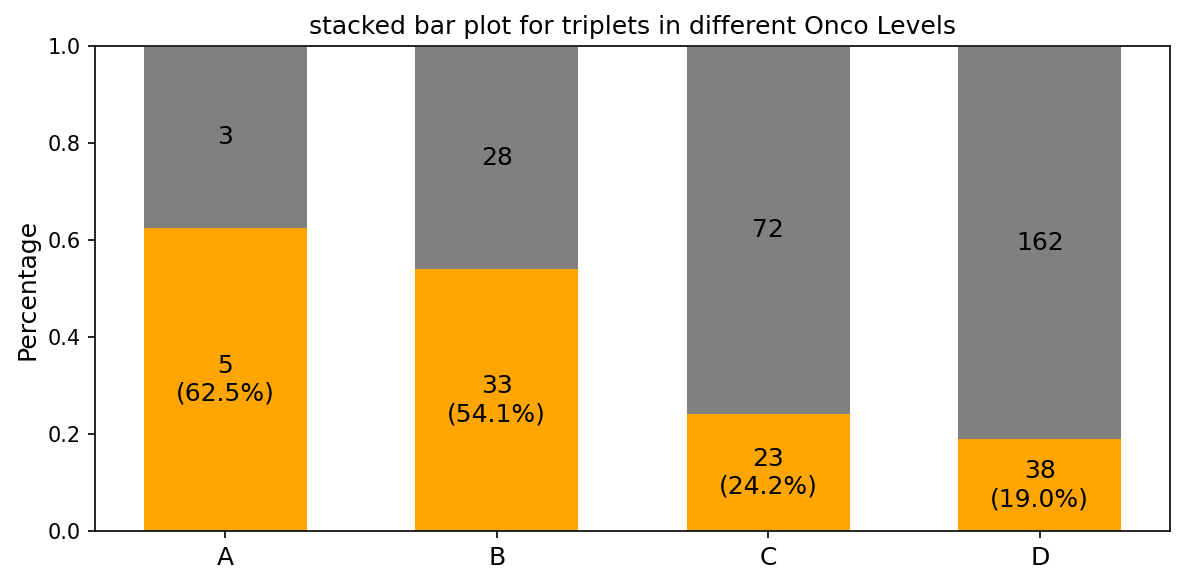

In [23]:
data = [Onco_A_counts, Onco_B_counts, Onco_C_counts, Onco_D_counts]
labels = ["A", "B", "C", "D"]

# Raw values
bottom_vals_raw = [d[0] + d[1] for d in data]   # orange
top_vals_raw = [d[2] for d in data]             # grey
totals = [bottom_vals_raw[i] + top_vals_raw[i] for i in range(len(data))]

# Convert to proportions
bottom_vals = [bottom_vals_raw[i] / totals[i] for i in range(len(data))]
top_vals = [top_vals_raw[i] / totals[i] for i in range(len(data))]

x = np.arange(len(labels))
width = 0.6

plt.figure(figsize=(8,4), dpi=150)

# Bottom (orange)
plt.bar(x, bottom_vals, width, label='First+Second', color='orange')

# Top (grey)
plt.bar(x, top_vals, width, bottom=bottom_vals, label='Third', color='grey')

# ----- Add text annotations -----
for i in range(len(labels)):

    # Orange stack: raw value + percentage
    plt.text(
        x[i],
        bottom_vals[i] / 2,
        f"{bottom_vals_raw[i]}\n({bottom_vals_raw[i]/totals[i]:.1%})",
        ha='center', va='center',
        fontsize=12, color='black'
    )

    # Grey stack: raw value only
    plt.text(
        x[i],
        bottom_vals[i] + top_vals[i] / 2,
        f"{top_vals_raw[i]}",
        ha='center', va='center',
        fontsize=12, color='black'
    )

plt.xticks(x, labels, fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.title("stacked bar plot for triplets in different Onco Levels", fontsize=12)

plt.ylim(0, 1)   # ensure all bars have height = 100%
plt.tight_layout()
plt.show()